In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install gym_cartpole_swingup

     |████████████████████████████████| 1.6MB 7.7MB/s 
  Created wheel for gym: filename=gym-0.18.0-cp37-none-any.whl size=1656450 sha256=d489c53be100b5dd6585270b67997d25bc1554c5d85fdf9287a265a60f033976
  Stored in directory: /root/.cache/pip/wheels/be/85/3b/480b828a4a697b37392740a040b8989f729d952b4e441a1877
Successfully built gym
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [4]:
pip install stable_baselines3

     |████████████████████████████████| 153kB 8.3MB/s 


In [5]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [6]:
import gym
import gym_cartpole_swingup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import seaborn as sb
import math
from IPython.display import clear_output
import time

In [15]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.ensemble import IsolationForest
from pyvirtualdisplay import Display

In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [9]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common import results_plotter

In [10]:
lbr = "\n"

Helper Functions

In [11]:
pathprefix = "/content/"
googledrive_dir = "/content/drive/MyDrive/ARL/"
os.makedirs(googledrive_dir, exist_ok=True)
log_dir1 = googledrive_dir + "logs1"
log_dir2 = googledrive_dir + "logs2"
log_dir = googledrive_dir + "logs"
os.makedirs(log_dir1, exist_ok=True)
os.makedirs(log_dir2, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

sample_dir = googledrive_dir + "samples" 
os.makedirs(sample_dir, exist_ok=True)

model_dir = googledrive_dir + "models"
os.makedirs(model_dir, exist_ok=True)

fig_dir = googledrive_dir + "figures"
os.makedirs(fig_dir, exist_ok=True)

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

ObservationWrapper

In [83]:
class NoisedObservationWrapper(gym.Wrapper):
    # encapsulate environment with this wrapper and use env just like before:
    # env = NoisedObservationWrapper(gym.make("CartPole-v0"))
    # for PPO2:
    # from stable_baselines.common import make_vec_env
    # env = make_vec_env(NoisedObservationWrapper(gym.make("CartPole-v0")))

    def __init__(self, env, std_dev=0.3, mean=0, angle_min=10, angle_max=20, local_path="false"):
        super().__init__(env)
        self.env = env
        self.std_dev = std_dev
        self.mean = mean
        self.angle_min = np.radians(angle_min)
        self.angle_max = np.radians(angle_max)
        self.local_path = local_path
        
        if(self.local_path != "false"):
            log_file = open(self.local_path, "w")
            log_file.close()

    def step(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)
        
        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()      
            
        return observation, reward, done, info
    
    def step_noise(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)
        
        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()      
            
        return observation, reward, done, info, noisy

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video')
  return env

Sampling Environment

In [14]:
CART_POS="cartPos"
CART_VEL="cartVel"
PEND_POS="pendPos"
PEND_POS_SIN="pendPosSin"
PEND_POS_COS="pendPosCos"
PEND_VEL="pendVel"
EPISODE="episode"
STEP="step"
ACTION="action"

d = {
        CART_POS:[], CART_VEL:[], 
        PEND_POS:[], PEND_VEL:[],
        EPISODE:[], STEP:[], ACTION:[]
    }

In [ ]:
# Setup Environment

goal_steps = 500
score_requirement =  100
initial_games = 10000
sample_episodes = 100
sample_max_length = 500
LR = 1e-3
env = wrap_env(NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0")))
env.reset()
env.np_random.seed(0)

array([ 0.05180545,  0.15284182, -0.99996555,  0.00830108, -0.18722917],
      dtype=float32)

In [ ]:
def sample_data():

    ### CREATE EMPTY Pandas dataset
    df = pd.DataFrame(data=d)

    ### SAMPLE DATA
    for episode in range (sample_episodes):
        obs = env.reset()
        step =0
        done = False
        
        while step < sample_max_length and not done:
            step += 1
            action = env.action_space.sample()
            action = action[0] # convert to float
            df = df.append ({CART_POS:obs[0], CART_VEL:obs[1], 
                            PEND_POS:obs[2], PEND_VEL:obs[3],
                            EPISODE:episode, STEP:step, ACTION:action}, ignore_index=True)
            
            obs, reward, done, _ = env.step(action)
        clear_output(wait=True)
        print("Sample Episode: " + str(episode+1))
    return df

In [ ]:
df = sample_data()

Sample Episode: 100


In [ ]:
sample_file = sample_dir + "/" + "sample200.csv"

In [ ]:
df.to_csv(path_or_buf=sample_file, index=False)

In [ ]:
samples = pd.read_csv(sample_file, engine='python', index_col=None)

Sample Examination

In [ ]:
samples.head()

,cartPos,cartVel,pendPos,pendVel,episode,step,action
0,0.047105,-0.065778,-0.996934,-0.078249,0.0,1.0,0.317565
1,0.046447,-0.010467,-0.996855,-0.079243,0.0,2.0,-0.300028
2,0.046343,-0.053637,-0.996901,-0.078671,0.0,3.0,-0.957797
3,0.045806,-0.201628,-0.996876,-0.078978,0.0,4.0,-0.868926
4,0.043790,-0.335168,-0.996569,-0.082769,0.0,5.0,-0.869852


In [ ]:
plot = samples.plot(subplots=True, figsize=(20,20), grid=True)
fig = plot[0].get_figure()
fig.savefig(fig_dir + "/sampleplot.png")

In [ ]:
row_max_steps = samples.loc[samples['step'].idxmax()]
print (row_max_steps)

In [ ]:
samplesEval = samples[samples.episode==row_max_steps.episode]
samplesEval.describe()

Dataset

In [13]:
markov_head = 4

In [ ]:
sample_length = len(samples.index)
print((samples[sample_length-1:sample_length]).to_numpy()[0][4])

199.0


In [ ]:
store = []

dataset = pd.DataFrame()

i = 0

print("Episode: " + str(0))

while (i < sample_length ) :

  new_data = (samples[i:i+1]).to_numpy()[0]

  pendPos = new_data[2]
  pendPosSin = math.sin(pendPos)
  pendPosCos = math.cos(pendPos)

  new_data[2] = pendPosSin
  new_data = np.insert(new_data, 3, pendPosCos)

  store.append(new_data)

  #print(new_data)

  if(len(store) == markov_head + 1):
    if store[0][5] == store[markov_head][5]:
        j = 0
        data = {}
        for j in range(markov_head+1):
          data[CART_POS + str(j+1)] = store[j][0]
          data[CART_VEL + str(j+1)] = store[j][1]
          data[PEND_POS_SIN + str(j+1)] = store[j][2]
          data[PEND_POS_COS + str(j+1)] = store[j][3]
          data[PEND_VEL + str(j+1)] = store[j][4]
          data[ACTION + str(j+1)] = store[j][7]

        #print(data)
        dataset = dataset.append (data, ignore_index=True)
        store.pop(0)
    else:
      clear_output(wait=True)
      print("Episode: " + str(store[markov_head][5]))
      store = [new_data]
  i += 1

print(dataset)

Episode: 1999.0
         action1   action2   action3  ...  pendVel3  pendVel4  pendVel5
0      -0.322456 -0.938358 -0.901102  ... -0.315415 -0.318757 -0.324048
1      -0.938358 -0.901102  0.358997  ... -0.318757 -0.324048 -0.327000
2      -0.901102  0.358997  0.533705  ... -0.324048 -0.327000 -0.327028
3       0.358997  0.533705  0.047232  ... -0.327000 -0.327028 -0.325766
4       0.533705  0.047232 -0.722394  ... -0.327028 -0.325766 -0.325798
...          ...       ...       ...  ...       ...       ...       ...
844651 -0.638094  0.918343  0.549583  ... -0.605822 -0.611436 -0.614326
844652  0.918343  0.549583  0.181291  ... -0.611436 -0.614326 -0.615274
844653  0.549583  0.181291  0.975912  ... -0.614326 -0.615274 -0.612673
844654  0.181291  0.975912 -0.862666  ... -0.615274 -0.612673 -0.610247
844655  0.975912 -0.862666  0.801695  ... -0.612673 -0.610247 -0.604592

[844656 rows x 30 columns]


In [17]:
processed_sample_file = sample_dir + "/" + "processed_sample_200.csv"

In [ ]:
dataset.to_csv(path_or_buf=processed_sample_file, index=False)

In [18]:
dataset = pd.read_csv(processed_sample_file, engine='python', index_col=None)

In [19]:
print(dataset)

        action1   action2   action3  ...  pendVel3  pendVel4  pendVel5
0      0.317565 -0.300028 -0.957797  ... -0.078671 -0.078978 -0.082769
1     -0.300028 -0.957797 -0.868926  ... -0.078978 -0.082769 -0.089680
2     -0.957797 -0.868926 -0.869852  ... -0.082769 -0.089680 -0.099686
3     -0.868926 -0.869852 -0.065332  ... -0.089680 -0.099686 -0.109566
4     -0.869852 -0.065332 -0.387545  ... -0.099686 -0.109566 -0.120548
...         ...       ...       ...  ...       ...       ...       ...
81043 -0.477167  0.557596  0.010023  ...  0.625119  0.606252  0.585305
81044  0.557596  0.010023 -0.409669  ...  0.606252  0.585305  0.561299
81045  0.010023 -0.409669  0.149883  ...  0.585305  0.561299  0.535339
81046 -0.409669  0.149883  0.090151  ...  0.561299  0.535339  0.507253
81047  0.149883  0.090151  0.213874  ...  0.535339  0.507253  0.477329

[81048 rows x 30 columns]


Uncertainty Modeling

In [20]:
inputs = []

j = 0
data = {}
for j in range(markov_head):
  inputs.append(CART_POS + str(j+1))
  inputs.append(CART_VEL + str(j+1))
  inputs.append(PEND_POS_SIN + str(j+1))
  inputs.append(PEND_POS_COS + str(j+1))
  inputs.append(PEND_VEL + str(j+1))
  inputs.append(ACTION + str(j+1))

outputs = [CART_POS + str(markov_head+1), CART_VEL + str(markov_head+1), PEND_POS_SIN + str(markov_head+1), PEND_POS_COS + str(markov_head+1), PEND_VEL + str(markov_head+1)]

print(inputs)
print(len(inputs))
print(outputs)
print(len(outputs))

['cartPos1', 'cartVel1', 'pendPosSin1', 'pendPosCos1', 'pendVel1', 'action1', 'cartPos2', 'cartVel2', 'pendPosSin2', 'pendPosCos2', 'pendVel2', 'action2', 'cartPos3', 'cartVel3', 'pendPosSin3', 'pendPosCos3', 'pendVel3', 'action3', 'cartPos4', 'cartVel4', 'pendPosSin4', 'pendPosCos4', 'pendVel4', 'action4']
24
['cartPos5', 'cartVel5', 'pendPosSin5', 'pendPosCos5', 'pendVel5']
5


In [21]:
input_data = dataset[inputs].values
output_data = dataset[outputs].values

NLL-Loss (based on https://fairyonice.github.io/Create-a-neural-net-with-a-negative-log-likelihood-as-a-loss.html)

In [53]:
n_epochs = 200
n_batch = 500

In [23]:
def mse(tensor1,tensor2, verbose=True):
    ## element wise square
    square = tf.square(tensor1 - tensor2)
    ## mean across the final dimensions
    ms = tf.reduce_mean(square)
    return(ms)

In [24]:
def weight_variable(shape):
    ## weight variable, initialized with truncated normal distribution
    initial = tf.truncated_normal(shape, stddev=0.01, dtype="float32")
    return tf.Variable(initial)

In [25]:
def bias_variable(shape):
    initial = tf.constant(0.001, shape=shape, dtype="float32")
    return tf.Variable(initial)

In [26]:
def fully_connected_layer(h0,n_h0,n_h1,verbose=True):
    '''
    h0   :  tensor of shape (n_h0, n_h1)
    n_h0 :  scalar 
    n_h1 :  scalar
    '''
    W1 = weight_variable([n_h0, n_h1])
    b1 = bias_variable([n_h1])
    
    if verbose:
        print("    h0.shape={}".format(h0.get_shape()))
        print("    W1.shape={}".format(W1.get_shape()))
        print("    b1.shape={}".format(b1.get_shape()))
    
    h1 = tf.matmul(h0, W1) + b1
    return(h1, (W1,b1))

In [ ]:
def fully_connected_layer_variational(h0,n_h0,n_h1,verbose=True):
    '''
    h0   :  tensor of shape (n_h0, n_h1)
    n_h0 :  scalar 
    n_h1 :  scalar
    '''
    W1 = weight_variable([n_h0, n_h1])
    b1 = bias_variable([n_h1])
    
    if verbose:
        print("    h0.shape={}".format(h0.get_shape()))
        print("    W1.shape={}".format(W1.get_shape()))
        print("    b1.shape={}".format(b1.get_shape()))
    
#[K, b] ~ Prior()
#M = matmul(X, K) + b
#Y ~ Likelihood(M)

# q = self._posterior(inputs)
# r = self._prior(inputs)
# self.add_loss(self._kl_divergence_fn(q, r))

    h1 = tf.matmul(h0, W1) + b1
    return(h1, (W1,b1))

In [27]:
def nll_gaussian(y_pred_mean,y_pred_sd,y_test):

    ## element wise square
    square = tf.square(y_pred_mean - y_test)## preserve the same shape as y_pred.shape
    ms = tf.add(tf.divide(square,y_pred_sd), tf.log(y_pred_sd))
    ## axis = -1 means that we take mean across the last dimension 
    ## the output keeps all but the last dimension
    ## ms = tf.reduce_mean(ms,axis=-1)
    ## return scalar
    ms = tf.reduce_mean(ms)
    return(ms)

In [65]:
def define_model(inputs, outputs ,n_hs,verbose=True,NLL=True):
    
    x_input = tf.placeholder(tf.float32, [None, len(inputs)])
    y_input = tf.placeholder(tf.float32, [None, len(outputs)])

    h_previous = x_input
    n_output = len(outputs)
    
    n_h_previous = len(inputs)
    paras = []
    for ilayer,n_h in enumerate(n_hs,1):
        if verbose:
            print("  layer:{}".format(ilayer))
        h, p = fully_connected_layer(h_previous,n_h_previous,n_h,verbose)
        h_previous = tf.nn.relu(h) 
        n_h_previous = n_h
        paras.append(p)
    if verbose:
        print("  output layer for y_mean")        
    y_mean,p = fully_connected_layer(h_previous,n_h_previous,n_output,verbose)
    paras.append(p)
    
    if NLL:
        if verbose:
            print("  output layer for y_sigma")  
        y_sigma, p = fully_connected_layer(h_previous,n_h_previous,n_output,verbose)
        ## for numerical stability this enforce the variance to be more than 1E-4
        y_sigma = tf.clip_by_value(t=tf.exp(y_sigma),
                                   clip_value_min=tf.constant(1E-4),
                                   clip_value_max=tf.constant(1E+100))

        paras.append(p)   
        loss = nll_gaussian(y_mean, y_sigma,y_input)
        y = [y_mean, y_sigma]
    else:
        loss = mse(y_mean, y_input)
        y = [y_mean]
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    inputs = [x_input, y_input]
    
    return(loss, train_step, inputs, y, paras)

In [34]:
def train(train_step,loss,input_array, x_train,y_train,n_epochs,n_batch):
    
    x_input, y_input = input_array
    
    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()
    
    

    lvalues = []
    for count in range(n_epochs):
          x_shuffle, y_shuffle = shuffle(x_train,y_train)
          for i in range(0,x_train.shape[0],n_batch):

              batch_xs = x_shuffle[i:i+n_batch]
              batch_ys = y_shuffle[i:i+n_batch]

              sess.run(train_step, 
                       feed_dict={x_input: batch_xs, 
                                  y_input: batch_ys})
          lv = sess.run(loss,
                        feed_dict={x_input: x_train, 
                                   y_input: y_train})
          lvalues.append(lv)
          clear_output(wait=True)
          print("  epoch={:05.0f}: {:5.3f}".format(count,lv))
    return(sess,lvalues,lv)

In [71]:
loss1, train_step1, input_array1, output_distributions1, _ = define_model(inputs, outputs, n_hs=[500,300,100])
[x_input1, y_input1] = input_array1
[output_mean1, output_sigma1] = output_distributions1

  layer:1
    h0.shape=(?, 24)
    W1.shape=(24, 500)
    b1.shape=(500,)
  layer:2
    h0.shape=(?, 500)
    W1.shape=(500, 300)
    b1.shape=(300,)
  layer:3
    h0.shape=(?, 300)
    W1.shape=(300, 100)
    b1.shape=(100,)
  output layer for y_mean
    h0.shape=(?, 100)
    W1.shape=(100, 5)
    b1.shape=(5,)
  output layer for y_sigma
    h0.shape=(?, 100)
    W1.shape=(100, 5)
    b1.shape=(5,)


In [72]:
start = time.time()
sess1, lvalues1, lv1 = train(train_step1,loss1, input_array1, input_data, output_data, n_epochs,n_batch)
clear_output(wait=True)
end = time.time()
print(end-start)

497.991495847702


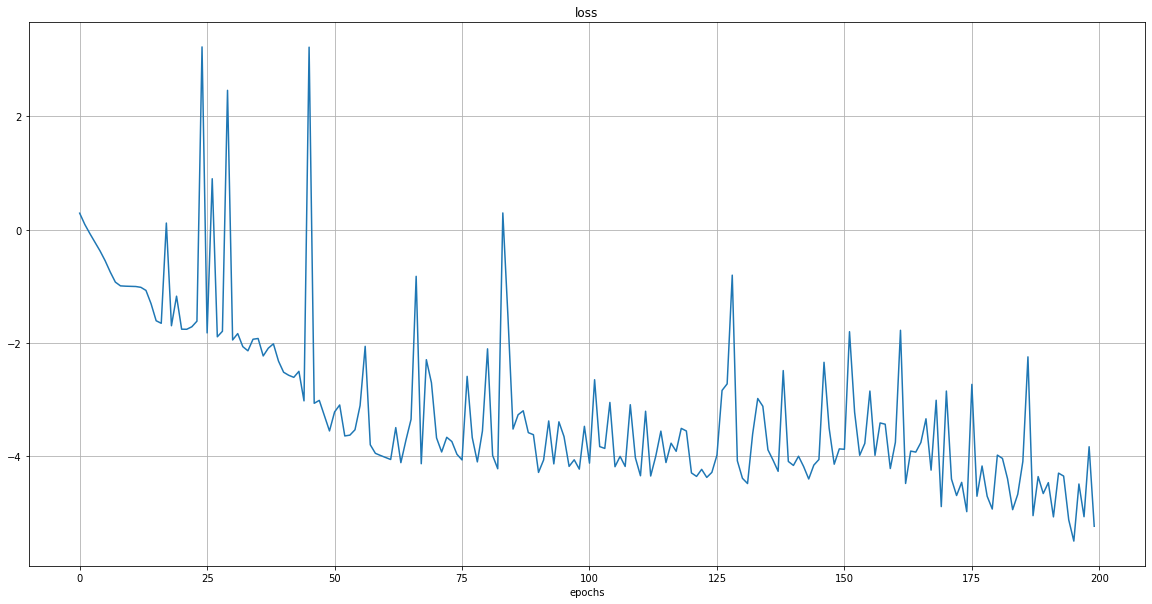

In [73]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

plt.plot(lvalues1)
plt.title("loss")
plt.xlabel("epochs")
plt.savefig(fig_dir + "/traningloss.png")
plt.show()

In [74]:
saver = tf.train.Saver()
modelSaveDir = model_dir + "/" + "sessSave1.ckpt"

In [75]:
saver.save(sess1, modelSaveDir)

'/content/drive/MyDrive/ARL/models/sessSave1.ckpt'

Test Model

In [76]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
saver.restore(sess, modelSaveDir)

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/ARL/models/sessSave1.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [77]:
output_mean_pred1  = sess.run(output_mean1,feed_dict={x_input1: input_data})
output_sigma_pred1 = sess.run(output_sigma1,feed_dict={x_input1: input_data})
print("RMSE: {}".format(np.sqrt(np.mean((output_data - output_mean_pred1)**2))))

RMSE: 0.037815194155473866


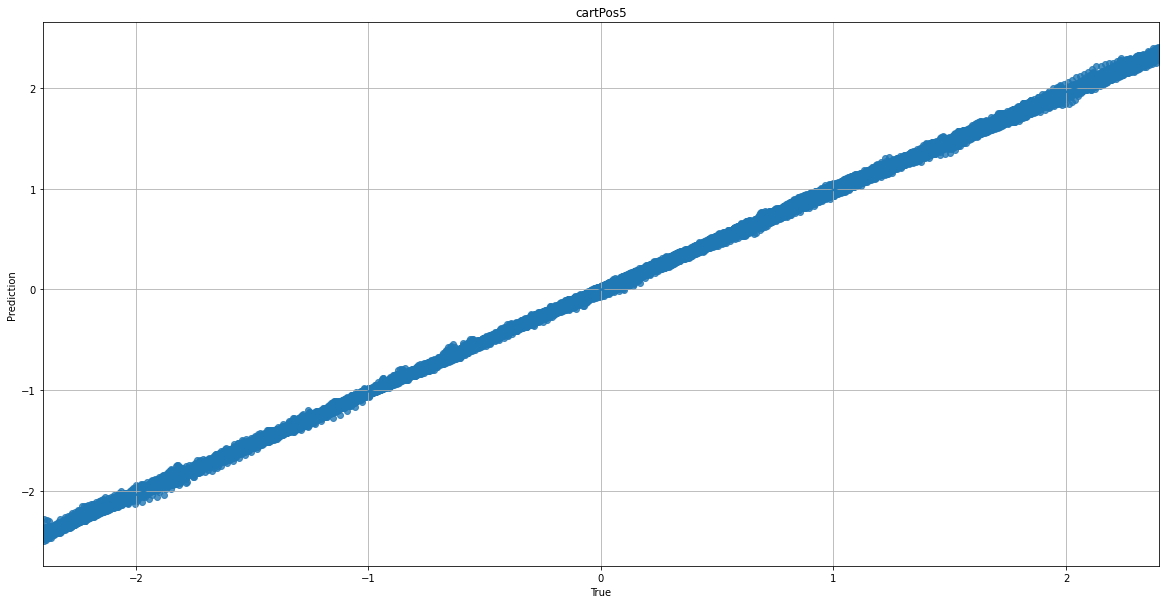

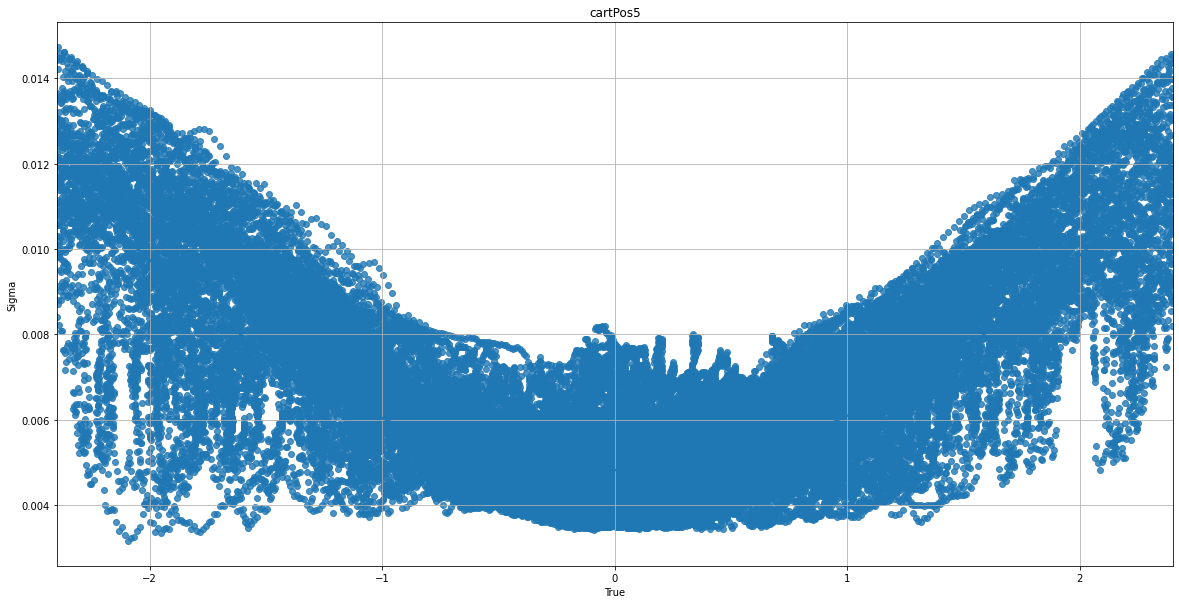

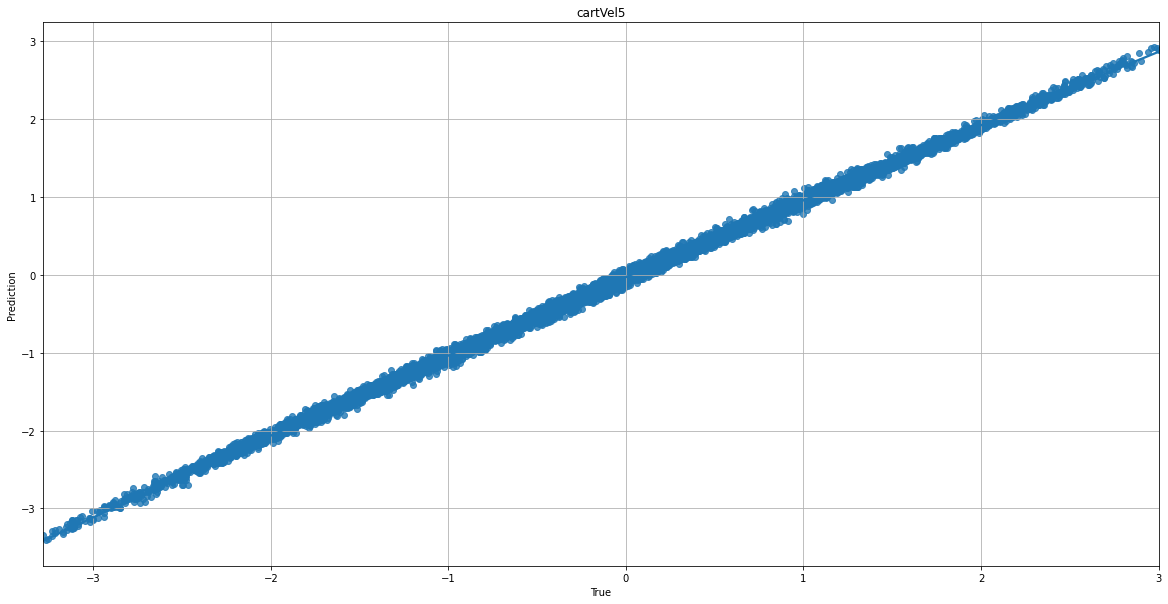

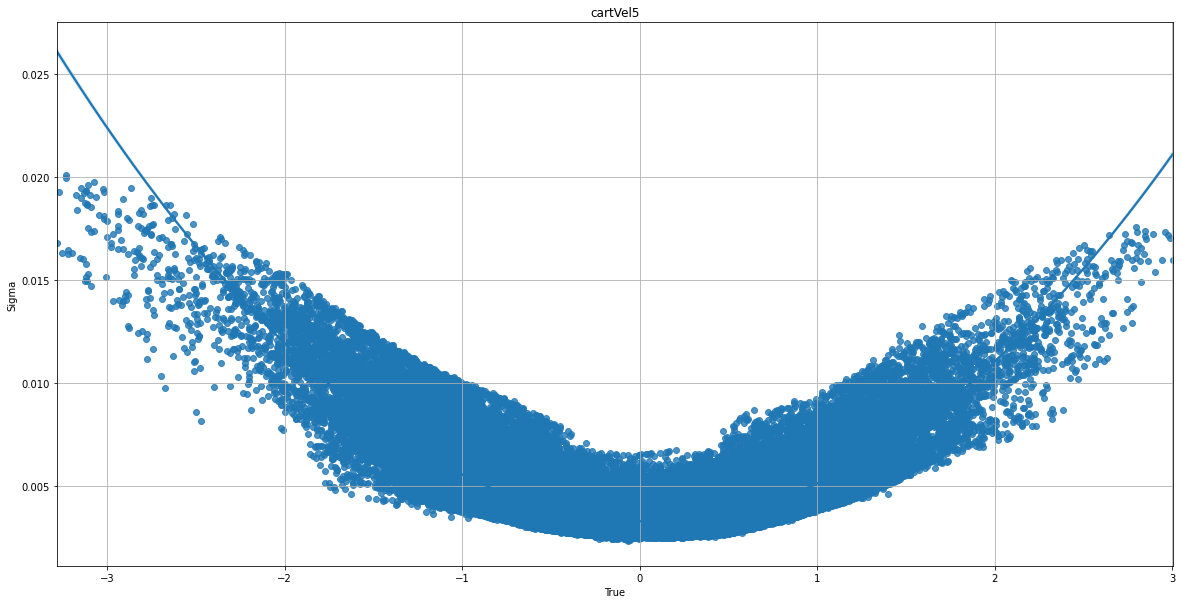

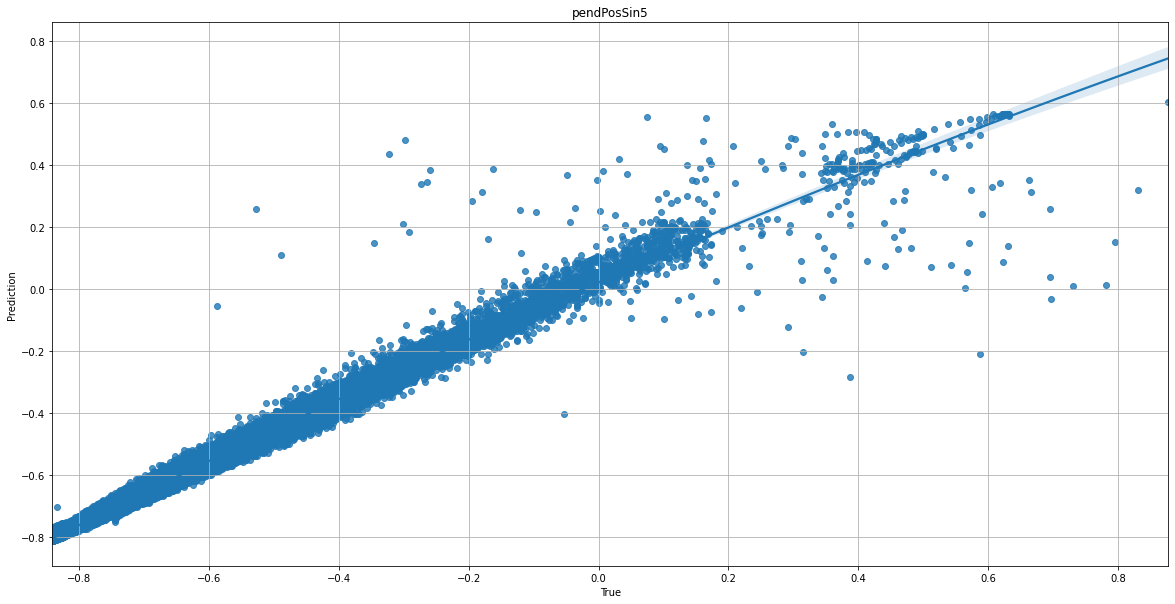

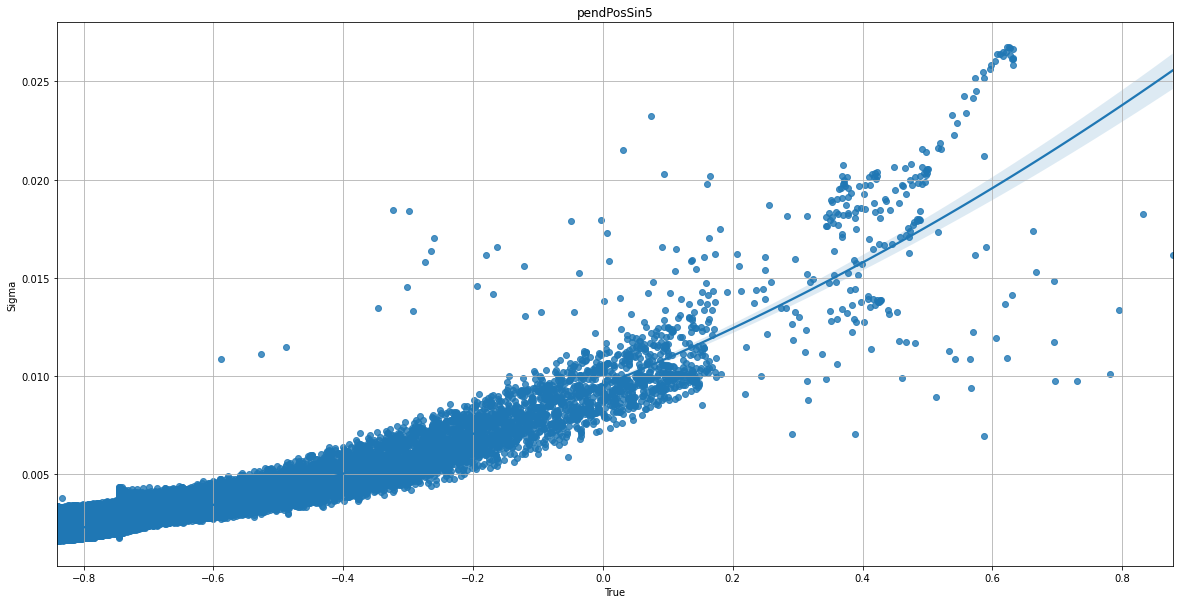

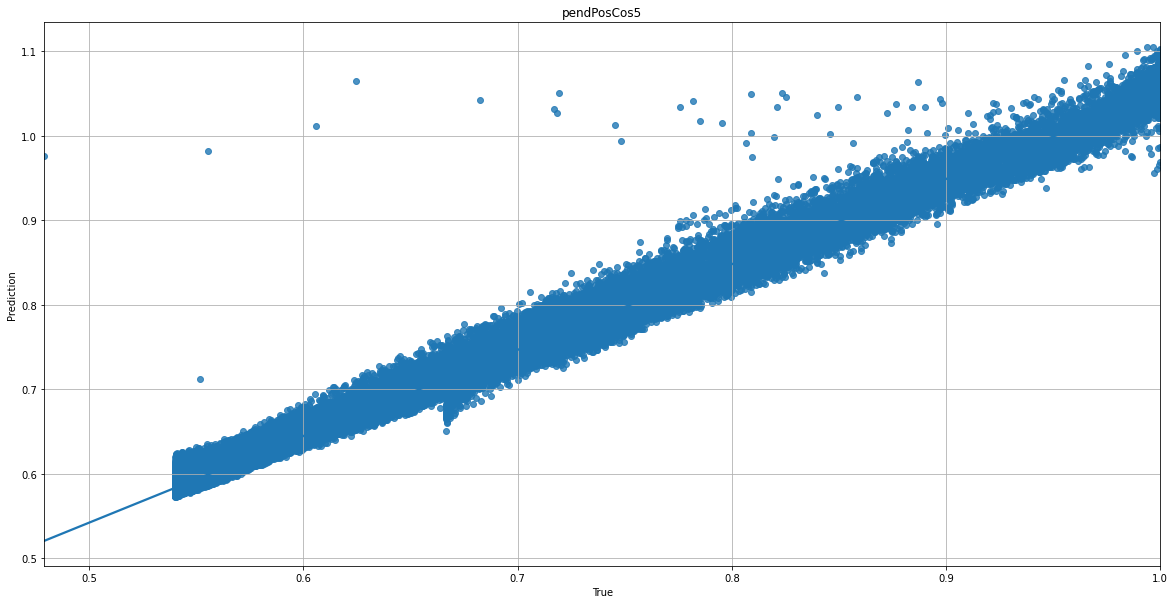

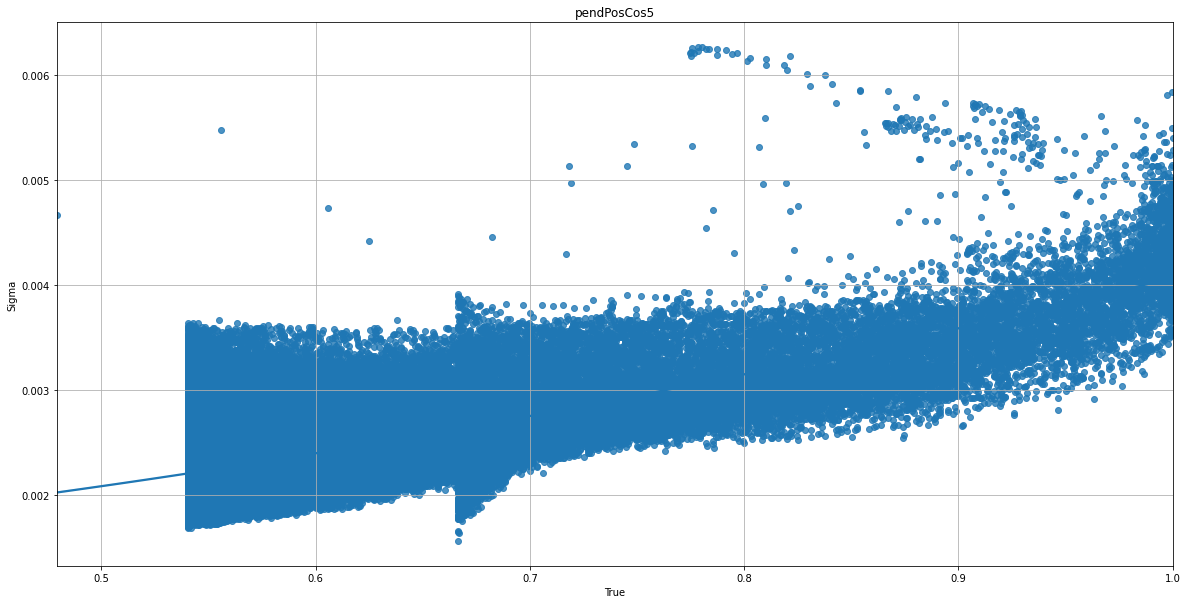

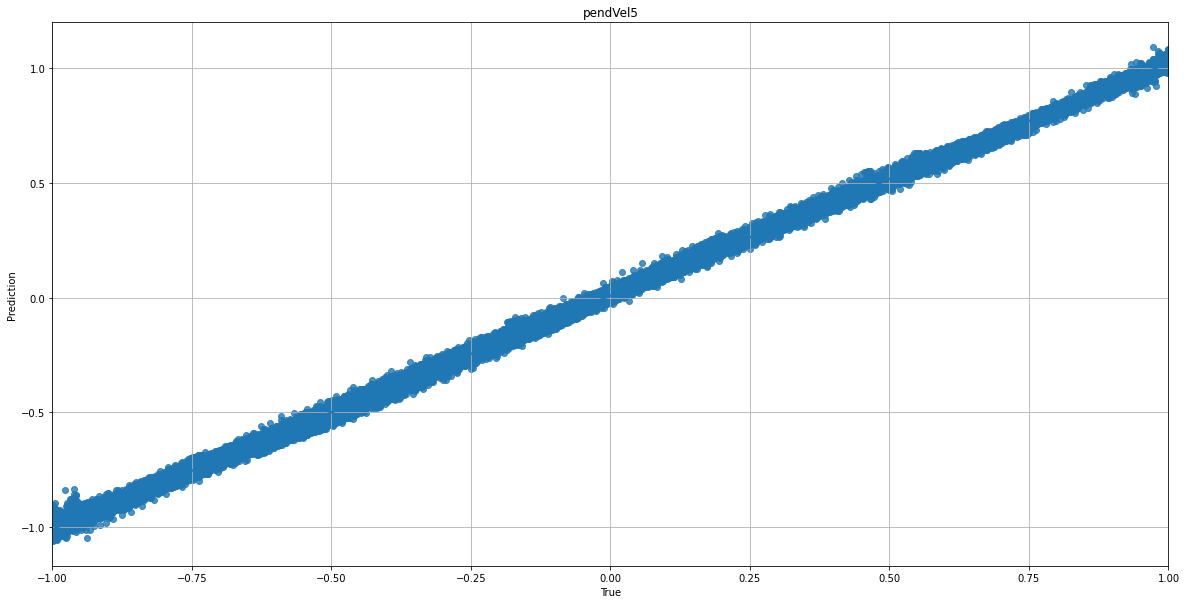

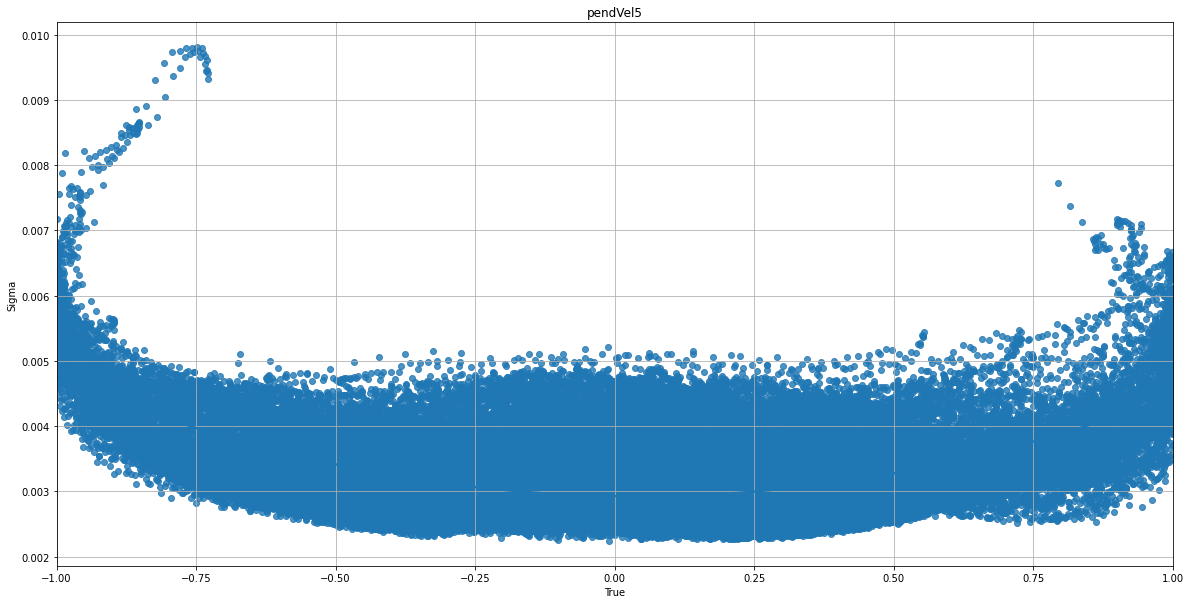

In [121]:
for i in range(len(outputs)):
  fig, regplot = plt.subplots(figsize = (20,10))


  sb.regplot(x=output_data[:,i], y=output_mean_pred1[:,i], fit_reg=True, scatter=True, order=2,truncate= True)

  regplot.set_xlabel("True")
  regplot.set_ylabel("Prediction")
  regplot.grid()

  plt.title(label=outputs[i])

  plt.savefig(fig_dir + "/predictplot" + outputs[i] + ".png")

  fig, regplot = plt.subplots(figsize = (20,10))

  sb.regplot(x=output_data[:,i], y=output_sigma_pred1[:,i], fit_reg=True, scatter=True, order=5,truncate= True)

  regplot.set_xlabel("True")
  regplot.set_ylabel("Sigma")
  regplot.grid()

  plt.title(label=outputs[i])

  plt.savefig(fig_dir + "/sigmapredictplot" + outputs[i] + ".png")

Noised Observation Wrapper with BNN

In [81]:
uncertainty_malus = -100

In [206]:
class NoisedObservationWrapperWithUncertaintyModelMalus(gym.Wrapper):
    # encapsulate environment with this wrapper and use env just like before:
    # env = NoisedObservationWrapper(gym.make("CartPole-v0"))
    # for PPO2:
    # from stable_baselines.common import make_vec_env
    # env = make_vec_env(NoisedObservationWrapper(gym.make("CartPole-v0")))

    def __init__(self, env, history, std_dev=0.3, mean=0, angle_min=10, angle_max=20, local_path="false",):
        super().__init__(env)
        self.env = env
        self.std_dev = std_dev
        self.mean = mean
        self.angle_min = np.radians(angle_min)
        self.angle_max = np.radians(angle_max)
        self.local_path = local_path
        self.history = history
        
        if(self.local_path != "false"):
            log_file = open(self.local_path, "w")
            log_file.close()

    def step(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)




        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        history = self.history
        print("History: " + str(history))
        if len(history) >= markov_head:
          cur_markov = np.concatenate(history).ravel()
          cur_markov.shape = (1,(len(inputs)))
          print(cur_markov.shape)
          prediction_mean = sess.run(output_mean1,feed_dict={x_input1: cur_markov})
          prediction_deviation = sess.run(output_sigma1,feed_dict={x_input1: cur_markov})
          print(prediction_mean)
          print(prediction_deviation)

          uncertainty = np.sum(prediction_deviation)
          print(uncertainty)

          print(str(uncertainty*uncertainty_malus))
          reward = reward + uncertainty*uncertainty_malus

        pendPos = observation[2]
        pendPosSin = math.sin(pendPos)
        pendPosCos = math.cos(pendPos)

        new_data = np.array(observation)
        new_data[2] = pendPosSin
        new_data = np.insert(new_data, 3, pendPosCos)

        history.append(new_data)
        if len(history) > markov_head:
          del(history[0])

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()

           
            
        return observation, reward, done, info
    
    def step_noise(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)
        
        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        # TODO - non-functional until model
        history.append(observation)
        if len(history) >= markov_head:
          del(history[0])

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()      
            
        return observation, reward, done, info, noisy

In [207]:
env3history = []
env3Test = NoisedObservationWrapperWithUncertaintyModelMalus(gym.make("CartPoleSwingUp-v0"), history = env3history)
env3Test = Monitor(env3Test, log_dir+str(3)) # required for using callback functions during training
env3Test = DummyVecEnv([lambda: env3Test])
env3Test = VecNormalize(env3Test, norm_obs=True, norm_reward=True) # State normalization

In [213]:
env3Test.reset()
env3Test.step(env3Test.action_space.sample())
env3Test.step(env3Test.action_space.sample())
env3Test.step(env3Test.action_space.sample())
env3Test.step(env3Test.action_space.sample())
env3Test.step(env3Test.action_space.sample())

History: [array([ 0.2162261 ,  0.02518118, -0.8403944 ,  0.5419754 , -0.06304836,
        0.06135799], dtype=float32), array([ 0.21647792, -0.0900366 , -0.8403733 ,  0.54200804, -0.0636607 ,
        0.33335102], dtype=float32), array([ 0.21557756, -0.01180195, -0.84025526,  0.542191  , -0.06698709,
        0.12253239], dtype=float32), array([ 0.21545953, -0.03967494, -0.8402103 ,  0.54226065, -0.06820961,
        0.17561302], dtype=float32)]
(1, 24)
[[ 0.20271239 -0.01220773 -0.8048817   0.5798419  -0.06663864]]
[[0.00419202 0.00263652 0.00192575 0.0019599  0.00265242]]
0.013366611
-1.3366610743105412
History: [array([ 0.21647792, -0.0900366 , -0.8403733 ,  0.54200804, -0.0636607 ,
        0.33335102], dtype=float32), array([ 0.21557756, -0.01180195, -0.84025526,  0.542191  , -0.06698709,
        0.12253239], dtype=float32), array([ 0.21545953, -0.03967494, -0.8402103 ,  0.54226065, -0.06820961,
        0.17561302], dtype=float32), array([ 0.08145235,  0.11769363, -0.841179  ,  0.54075

(array([[-0.16483317,  1.7461737 , -0.84140515, -0.4687801 , -1.0368351 ]],
       dtype=float32),
 array([-0.61124486], dtype=float32),
 array([False]),
 [{}])

Test Environments

In [ ]:
env1Test = gym.make('CartPoleSwingUp-v0')
env1Test = Monitor(env1Test, log_dir1) # required for using callback functions during training
env1Test = DummyVecEnv([lambda: env1Test])
env1Test = VecNormalize(env1Test, norm_obs=True, norm_reward=True) # State normalization

In [ ]:
env2Test = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"))
env2Test = Monitor(env2Test, log_dir2) # required for using callback functions during training
env2Test = DummyVecEnv([lambda: env2Test])
env2Test = VecNormalize(env2Test, norm_obs=True, norm_reward=True) # State normalization

Experiment settings

In [ ]:
time_steps=30000
num_experiments = 2
sampleCount = 100

Experiments without Uncertainty

In [ ]:
tensorboard_dir1 = "cartpole1"
os.makedirs(tensorboard_dir1, exist_ok=True)
time = []
for e in range (1, (num_experiments+1), 1):
    env1Test.reset()
    log_dir = (log_dir1+ str(e))
    os.makedirs(log_dir, exist_ok=True)
    env1 = gym.make('CartPoleSwingUp-v0')
    env1 = Monitor(env1, log_dir) # required for using callback functions during training
    env1 = DummyVecEnv([lambda: env1])
    env1 = VecNormalize(env1, norm_obs=True, norm_reward=True) # State normalization
    model1 = PPO(MlpPolicy, env1, verbose=0)
    
    clear_output(wait=True)
    print("Run " +  str(e))
    

    eval_callback = EvalCallback(env1Test, best_model_save_path=log_dir,
                             log_path=log_dir, eval_freq=1000,
                             deterministic=True, render=False)
    
    
    start = time.time()
    model1.learn(total_timesteps=time_steps, callback=eval_callback)
    end = time.time()
    time.insert(end-start)
    env1.close()
print(time)    
    

Run 2
Eval num_timesteps=1000, episode_reward=-487.49 +/- 16.44
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-489.24 +/- 12.78
Episode length: 500.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-442.40 +/- 29.33
Episode length: 489.80 +/- 20.40
New best mean reward!
Eval num_timesteps=4000, episode_reward=-416.81 +/- 61.04
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5000, episode_reward=-211.47 +/- 24.66
Episode length: 250.60 +/- 46.12
New best mean reward!
Eval num_timesteps=6000, episode_reward=-222.03 +/- 22.36
Episode length: 240.00 +/- 28.06
Eval num_timesteps=7000, episode_reward=-191.75 +/- 25.27
Episode length: 218.20 +/- 41.78
New best mean reward!
Eval num_timesteps=8000, episode_reward=-156.10 +/- 30.13
Episode length: 308.80 +/- 101.41
New best mean reward!
Eval num_timesteps=9000, episode_reward=-113.12 +/- 38.32
Episode length: 259.00 +/- 64.88
New best mean reward!
Eval num_timesteps=1000

Experiment Results without Uncertainty

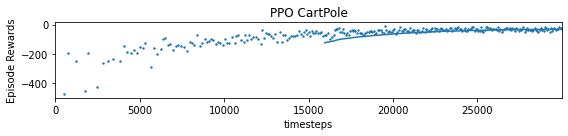

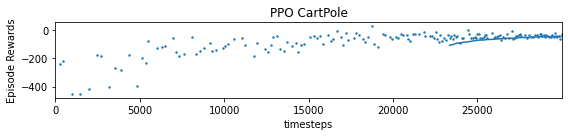

In [ ]:
for e in range (1, (num_experiments+1), 1):
    results_plotter.plot_results([log_dir1+str(e)], time_steps, results_plotter.X_TIMESTEPS, "PPO CartPole")

    plt.savefig(fig_dir + "/Results_PPO_" + str(e)  + ".png")
    plt.show()


Best Policy: 2


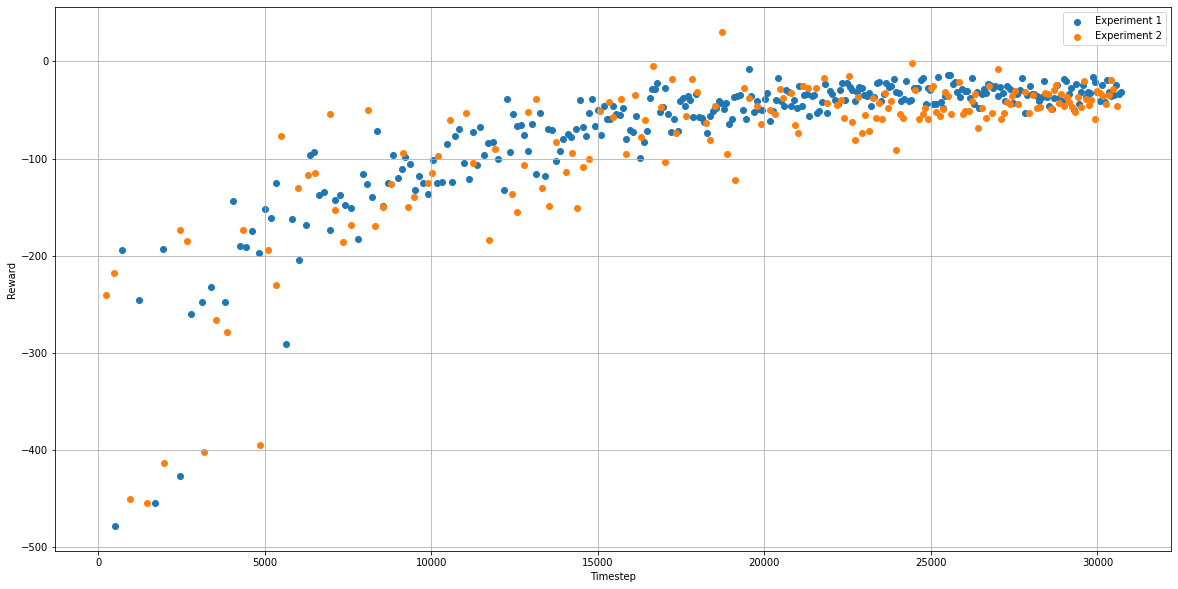

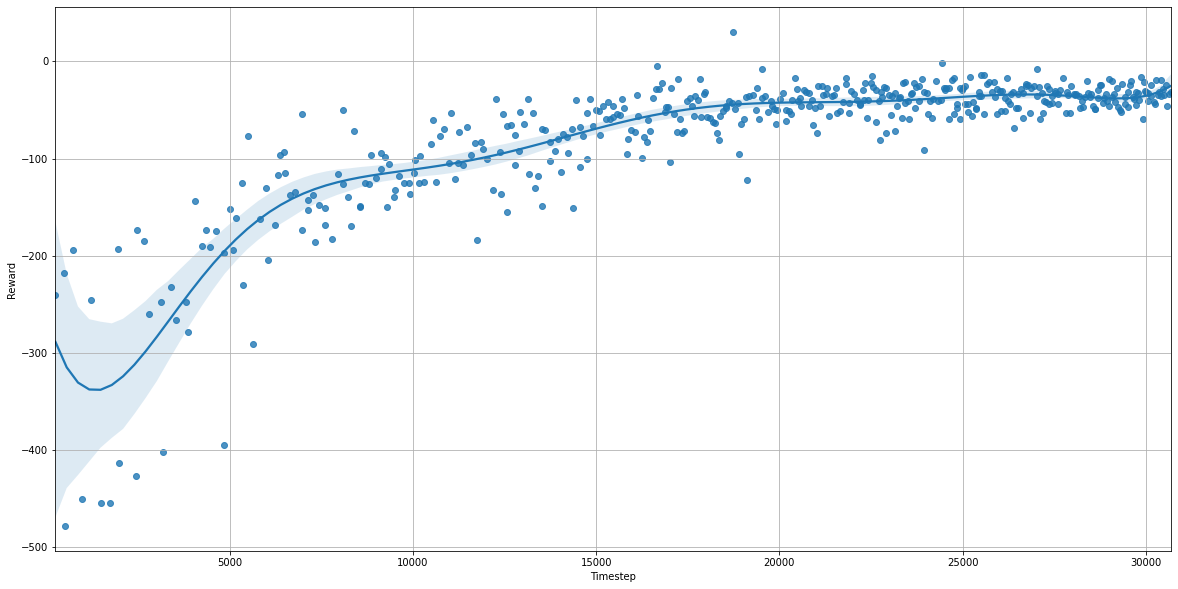

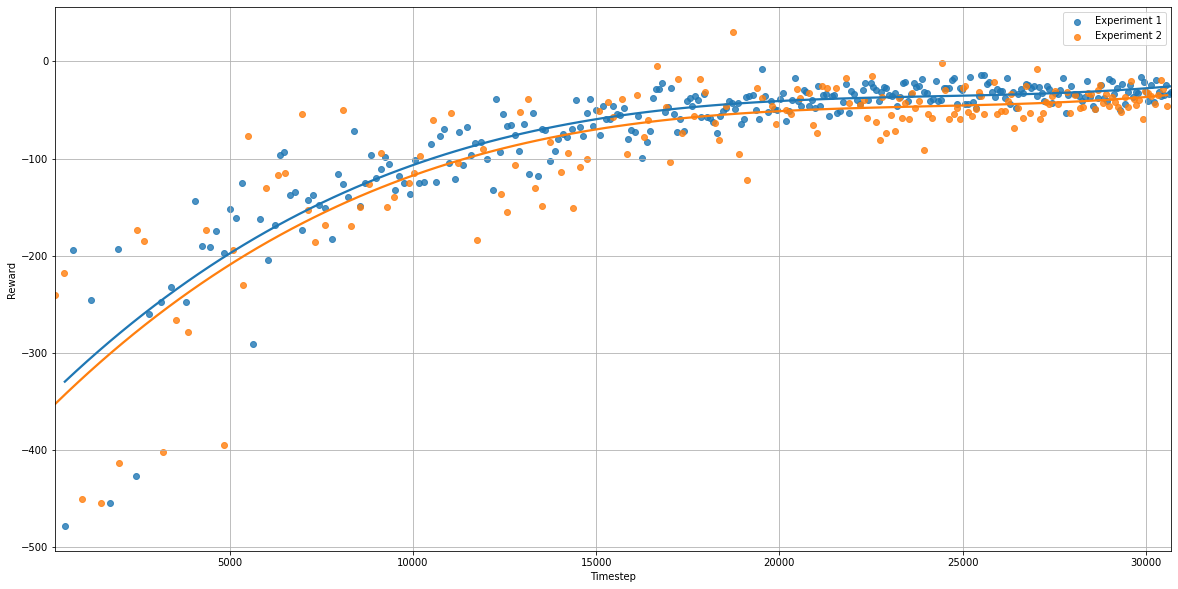

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

store1 = pd.DataFrame()
exps1 = []

maxreward1 = - math.inf
best1 = 0

for e in range (1, (num_experiments+1), 1):
    log_dir = (log_dir1+ str(e))
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    plt.scatter(x=x, y=y, label="Experiment " + str(e))
    #plt.plot(x, y)
    d = {'x': x, 'y': y}
    exp1 = pd.DataFrame(d)
    exps1.append(exp1)
    store1 = store1.append(exp1, ignore_index=True)
    if (np.max(y) > maxreward1):
      best1 = e

print("Best Policy: " + str(best1))

plt.legend()
plt.ylabel("Reward")
plt.xlabel("Timestep")

#plt.plot(x_mean, y_mean)
#print(store1)

plt.savefig(fig_dir + "/Results_PPO_Points.png")
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
regplot=sb.regplot(x="x", y="y", data=store1, fit_reg=True, scatter=True, order=8,truncate= True)
regplot.grid()
regplot.set_ylabel("Reward")
regplot.set_xlabel("Timestep")

plt.savefig(fig_dir + "/Results_PPO_Combined.png")
plt.show()

fig, regplot2 = plt.subplots(figsize = (20,10))
i = 0
for exp1 in exps1:
    i += 1
    sb.regplot(x="x", y="y", data=exp1, fit_reg=True, scatter=True, order=3,truncate= True, ci=None, label="Experiment " + str(i))
regplot2.grid()
regplot2.legend()
regplot2.set_ylabel("Reward")
regplot2.set_xlabel("Timestep")
plt.savefig(fig_dir + "/Results_PPO_Regression.png")
plt.show()

In [ ]:
import pandas as pd
path = googledrive_dir + "logs11/monitor.csv"
data = pd.read_csv(str(path), engine='python', index_col=None, skiprows=1)
#print(data)
data.sum(axis=0)


r   -19614.790597
l    30698.000000
t    14377.496998
dtype: float64

Experiments with Uncertainty

In [ ]:
tensorboard_dir2 = "cartpole2"
os.makedirs(tensorboard_dir2, exist_ok=True)
time = []
for e in range (1, (num_experiments+1), 1):

    log_dir = (log_dir2 + str(e))
    os.makedirs(log_dir, exist_ok=True)
    env2 = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"))
    env2 = Monitor(env2, log_dir) # required for using callback functions during training
    env2 = DummyVecEnv([lambda: env2])
    env2 = VecNormalize(env2, norm_obs=True, norm_reward=True)

    model2 = PPO(MlpPolicy, env2, verbose=0)

    clear_output(wait=True)
    print("Run " +  str(e))

    eval_callback = EvalCallback(env2Test, best_model_save_path=log_dir,
                             log_path=log_dir, eval_freq=1000,
                             deterministic=True, render=False)

    start = time.time()
    model2.learn(total_timesteps=time_steps, callback=eval_callback)
    end = time.time()
    time.insert(end-start)
    env2.close()
print(time)

Run 2
Eval num_timesteps=1000, episode_reward=-494.30 +/- 4.27
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-486.20 +/- 16.65
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=-311.52 +/- 69.94
Episode length: 318.60 +/- 70.47
New best mean reward!
Eval num_timesteps=4000, episode_reward=-310.11 +/- 89.86
Episode length: 326.40 +/- 103.66
New best mean reward!
Eval num_timesteps=5000, episode_reward=-220.52 +/- 34.81
Episode length: 227.80 +/- 28.39
New best mean reward!
Eval num_timesteps=6000, episode_reward=-232.09 +/- 27.67
Episode length: 312.80 +/- 97.87
Eval num_timesteps=7000, episode_reward=-200.84 +/- 36.75
Episode length: 223.60 +/- 34.14
New best mean reward!
Eval num_timesteps=8000, episode_reward=-198.18 +/- 59.35
Episode length: 216.00 +/- 74.11
New best mean reward!
Eval num_timesteps=9000, episode_reward=-157.19 +/- 40.61
Episode length: 170.60 +/- 37.94
New best mean reward!
E

Experiment Results with Uncertainty 

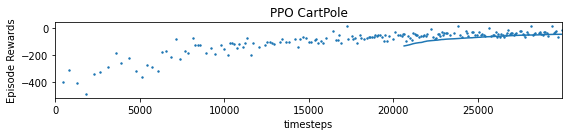

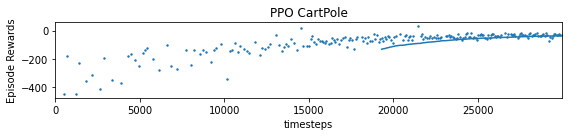

In [ ]:
for e in range (1, (num_experiments+1), 1):

    results_plotter.plot_results([log_dir2+str(e)], time_steps, results_plotter.X_TIMESTEPS, "PPO CartPole")
    plt.savefig(fig_dir + "/Results_PPO_Uncertain_" + str(e)  + ".png")
    plt.show()

Best Policy: 2


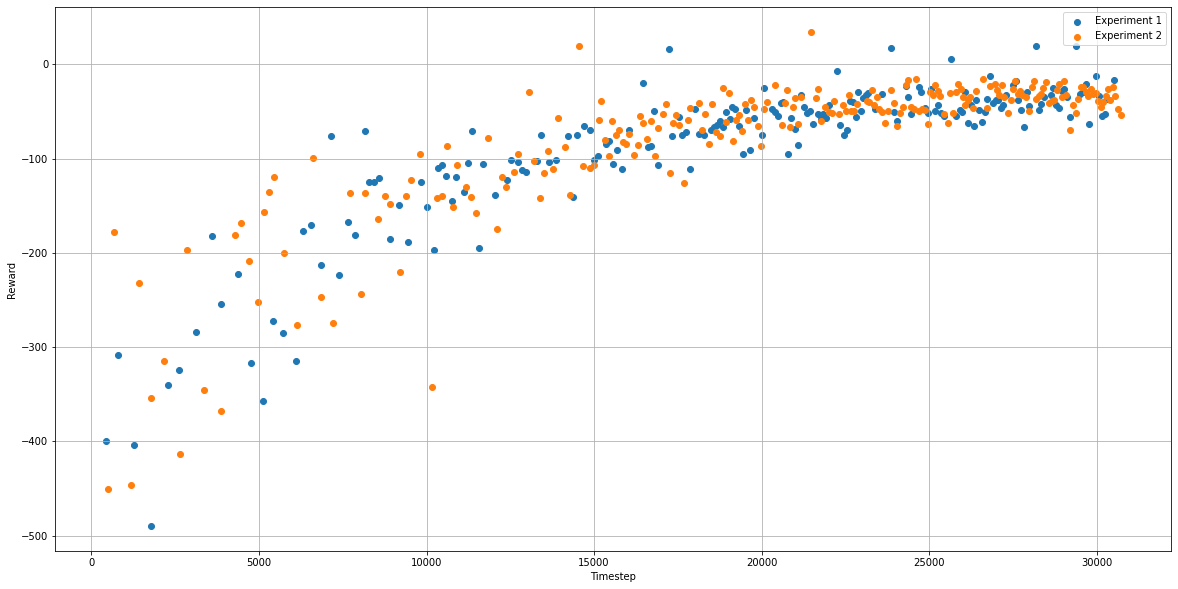

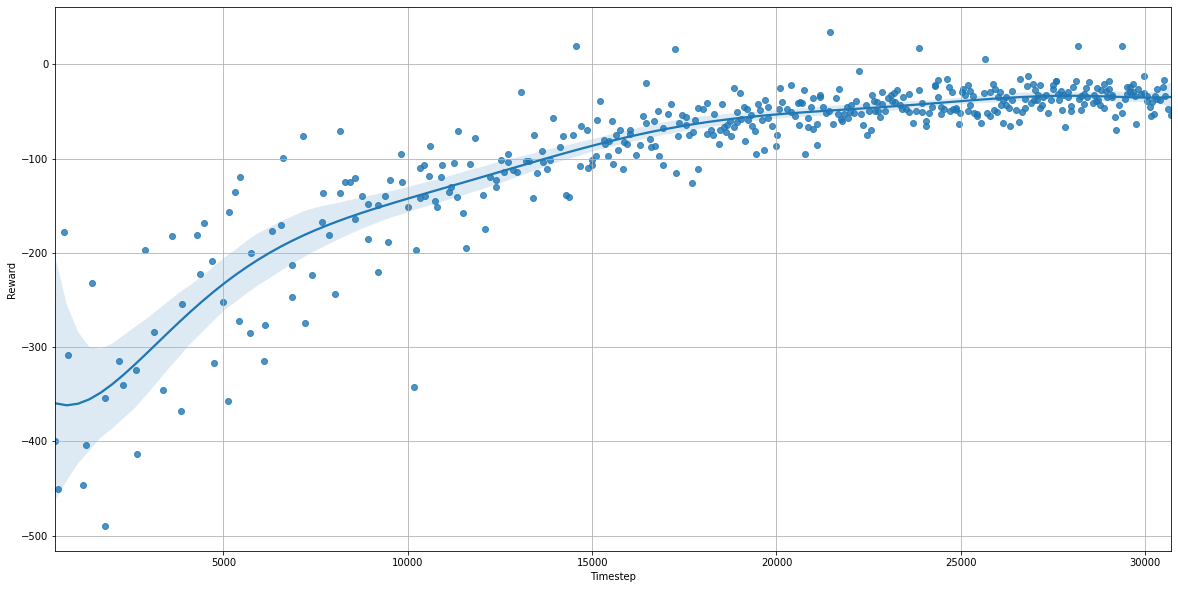

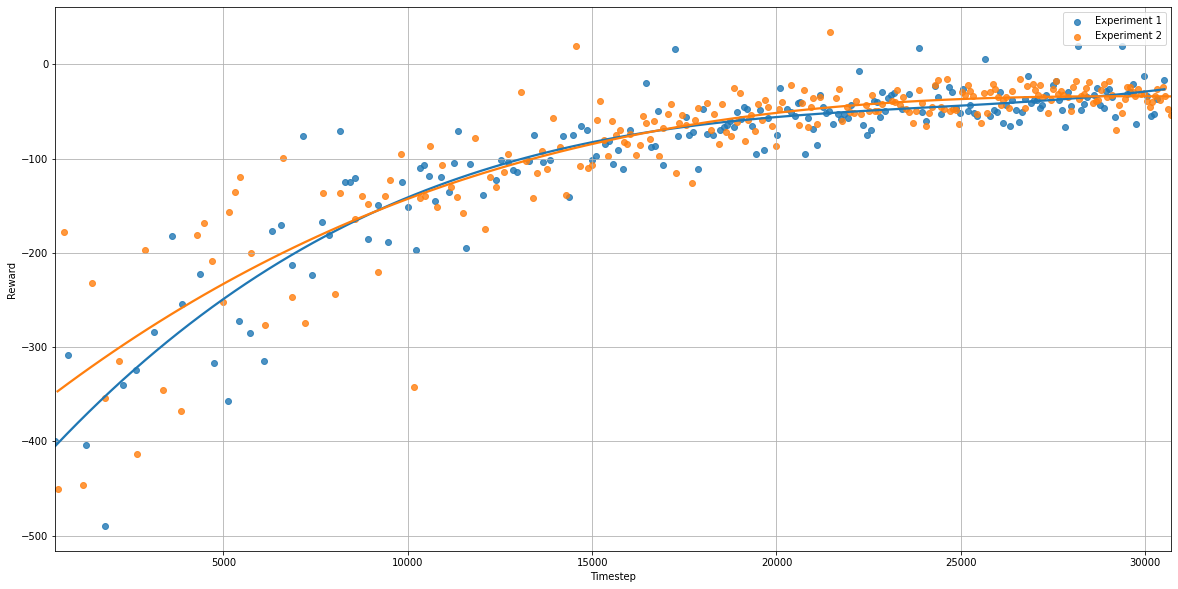

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

maxreward2 = -math.inf
best2 = 0

store2 = pd.DataFrame()
exps2 = []
for e in range (1, (num_experiments+1), 1):
    log_dir = (log_dir2+ str(e))
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    plt.scatter(x=x, y=y, label = "Experiment " + str(e))
    #plt.plot(x, y)
    d = {'x': x, 'y': y}
    exp2 = pd.DataFrame(d)
    exps2.append(exp2)
    store2 = store2.append(exp2, ignore_index=True)
    if (np.max(y) > maxreward2):
      best2 = e

print("Best Policy: " + str(best2))

plt.legend()
plt.ylabel("Reward")
plt.xlabel("Timestep")
#plt.plot(x_mean, y_mean)
#print(store)
plt.savefig(fig_dir + "/Results_PPO_Uncertain_Points.png")
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
fig.clf()
regplot=sb.regplot(x="x", y="y", data=store2, fit_reg=True, scatter=True, order=8,truncate= True)
regplot.grid()
regplot.set_ylabel("Reward")
regplot.set_xlabel("Timestep")
plt.savefig(fig_dir + "/Results_PPO_Uncertain_Combined.png")
plt.show()

fig, regplot2 = plt.subplots(figsize = (20,10))
i = 0
for exp2 in exps2:
    i += 1
    sb.regplot(x="x", y="y", data=exp2, fit_reg=True, scatter=True, order=3,truncate= True, ci=None, label = "Experiment " + str(i))
regplot2.grid()
regplot2.legend()
regplot2.set_ylabel("Reward")
regplot2.set_xlabel("Timestep")
plt.savefig(fig_dir + "/Results_PPO_Uncertain_Regression.png")
plt.show()



Evaluation of best model



In [ ]:
models = []
models.append(PPO.load("%s/best_model.zip" % (log_dir1+str(best1))))
models.append(PPO.load("%s/best_model.zip" % (log_dir1+str(best2))))

index = []
index.append(1)
index.append(2)

In [ ]:

env = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"), local_path="test.txt")
env = Monitor(env, log_dir) # required for using callback functions during training

env.training=False

expCounter1 = []

exp = 1

while exp <= sampleCount:
    state = env.reset()
    done=False
    cumReward = 0
    steps=0
    noise = 0
    neg = 0
    pos = 0
    while not done: 
        steps += 1
        action, _states = models[0].predict(state)
        state, reward, done, _, noisy = env.step_noise(action)
        cumReward += reward

        if (action[0]> 0):
            pos += 1
        elif (action[0]< 0):
            neg += 1

        if noisy:
            noise += 1

    env.close()

    if neg > 0:
      negReward = cumReward / neg
      negNoise = noise / neg
    else:
      negReward = 0
      negNoise = 0

    if pos > 0:
      posReward = cumReward / pos
      posNoise = noise / pos
    else:
      posReward = 0
      posNoise = 0
    
    expCounter1.append([steps, cumReward, noise, neg, pos, negReward, posReward, negNoise, posNoise])
    
    clear_output(wait=True)
    print("Experiment " +  str(exp) + " Reward: " + str(cumReward) + " Steps: " + str(neg) + "/" + str(pos) + " Noise: " + str(noise))
    exp+= 1

results1 = np.mat(expCounter1)
#print(results)
clear_output(wait=True)

print ("Average Reward: %.3f" % (np.mean(np.array(results1[:,1]))))
print ("Average Step Count: %.3f" % (np.mean(np.array(results1[:,0]))))
print ("Average Noise: %.3f" % (np.mean(np.array(results1[:,2]))))
print ("Average Noise per Length: %.3f" % (np.mean(np.divide(np.array(results1[:,2]),np.array(results1[:,0])))))
print("Steps: " + str(np.sum(np.array(results1[:,3]))) + "/" + str(np.sum(np.array(results1[:,4]))) )
print("Steps Ratio (Neg): " + str(np.mean(np.divide(np.array(results1[:,3]),np.array(results1[:,0])))))
print("Steps Ratio (Pos): " + str(np.mean(np.divide(np.array(results1[:,4]),np.array(results1[:,0])))))
print("Average Reward per Negative: " + str(np.mean(np.array(results1[:,5]))))
print("Average Reward per Positive: " + str(np.mean(np.array(results1[:,6]))))
print("Average Noise per Negative: " + str(np.mean(np.array(results1[:,7]))))
print("Average Noise per Positive: " + str(np.mean(np.array(results1[:,8]))))

Experiment 100 Reward: 36.43055941257626 Steps: 100/175 Noise: 9


In [ ]:
results1df = pd.DataFrame(data=results1, columns=["steps", "reward", "noise" , "neg", "pos", "negReward", "posReward", "negNoise", "posNoise"])
results1df.to_csv(path_or_buf=log_dir + "1/results.csv", index=False)

In [ ]:
loaded1 = pd.read_csv(log_dir + "1/results.csv", engine='python', index_col=None)
print(loaded1)

    steps      reward  noise    neg  ...  negReward  posReward  negNoise  posNoise
0   221.0   20.605889    7.0  132.0  ...   0.156105   0.231527  0.053030  0.078652
1   314.0  150.008993    2.0  176.0  ...   0.852324   1.087022  0.011364  0.014493
2   361.0  125.624452    8.0  142.0  ...   0.884679   0.573628  0.056338  0.036530
3   270.0   83.637951    6.0   97.0  ...   0.862247   0.483456  0.061856  0.034682
4   394.0  147.961624   10.0  148.0  ...   0.999741   0.601470  0.067568  0.040650
..    ...         ...    ...    ...  ...        ...        ...       ...       ...
95  309.0   65.100311   12.0  119.0  ...   0.547061   0.342633  0.100840  0.063158
96  209.0  -16.002392    9.0  144.0  ...  -0.111128  -0.246191  0.062500  0.138462
97  251.0   82.027954    2.0  149.0  ...   0.550523   0.804196  0.013423  0.019608
98  230.0  -10.931597    7.0   85.0  ...  -0.128607  -0.075390  0.082353  0.048276
99  275.0   36.430559    9.0  100.0  ...   0.364306   0.208175  0.090000  0.051429

[10

In [ ]:
env = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"), local_path="test.txt")
env = Monitor(env, log_dir) # required for using callback functions during training

env.training=False

expCounter2 = []

exp = 1
while exp <= sampleCount:
    state = env.reset()
    done=False
    cumReward = 0
    steps=0
    noise = 0
    neg = 0
    pos = 0

    while not done: 
        steps += 1
        action, _states = models[1].predict(state)
        state, reward, done, _, noisy = env.step_noise(action)
        cumReward += reward
        
        if (action[0]> 0):
            pos += 1
        elif (action[0]< 0):
            neg += 1

        if noisy:
            noise += 1

    env.close()
    
    if neg > 0:
      negReward = cumReward / neg
      negNoise = noise / neg
    else:
      negReward = 0
      negNoise = 0

    if pos > 0:
      posReward = cumReward / pos
      posNoise = noise / pos
    else:
      posReward = 0
      posNoise = 0
    
    expCounter2.append([steps, cumReward, noise, neg, pos, negReward, posReward, negNoise, posNoise])
    
    clear_output(wait=True)
    print("Experiment " +  str(exp) + " Reward: " + str(cumReward) + " Steps: " + str(neg) + "/" + str(pos) + " Noise: " + str(noise))
    exp+= 1

results2 = np.mat(expCounter2)
#print(results)


clear_output(wait=True)

print ("Average Reward: %.3f" % (np.mean(np.array(results2[:,1]))))
print ("Average Step Count: %.3f" % (np.mean(np.array(results2[:,0]))))
print ("Average Noise: %.3f" % (np.mean(np.array(results2[:,2]))))
print ("Average Noise per Length: %.3f" % (np.mean(np.divide(np.array(results2[:,2]),np.array(results2[:,0])))))
print("Steps: " + str(np.sum(np.array(results2[:,3]))) + "/" + str(np.sum(np.array(results2[:,4]))) )
print("Steps Ratio (Neg): " + str(np.mean(np.divide(np.array(results2[:,3]),np.array(results2[:,0])))))
print("Steps Ratio (Pos): " + str(np.mean(np.divide(np.array(results2[:,4]),np.array(results2[:,0])))))
print("Average Reward per Negative: " + str(np.mean(np.array(results2[:,5]))))
print("Average Reward per Positive: " + str(np.mean(np.array(results2[:,6]))))
print("Average Noise per Negative: " + str(np.mean(np.array(results2[:,7]))))
print("Average Noise per Positive: " + str(np.mean(np.array(results2[:,8]))))

Average Reward: 38.195
Average Step Count: 235.770
Average Noise: 6.740
Average Noise per Length: 0.027
Steps: 10462.0/13115.0
Steps Ratio (Neg): 0.4750444078041084
Steps Ratio (Pos): 0.5249555921958917
Average Reward per Negative: 0.16491877796129079
Average Reward per Positive: -0.040485593895230855
Average Noise per Negative: 0.06802006796386027
Average Noise per Positive: 0.04938832795827849


In [ ]:
results2df = pd.DataFrame(data=results2, columns=["steps", "reward", "noise" , "neg", "pos", "negReward", "posReward", "negNoise", "posNoise"])
results2df.to_csv(path_or_buf=log_dir + "2/results.csv", index=False)

Graph Content


In [ ]:
variants = ["PPO (Base, no noise)", "PPO (Base, noise)"]

In [ ]:
stepCounter = []
rewardCounter = []
noiseCounter = []
negCounter = []
posCounter = []
avgNoiseCounter = []
negRewardCounter = []
posRewardCounter = []
negNoiseCounter = []
posNoiseCounter = []
stepRatio = []

for i in range(len(variants)) :
  loaded = pd.read_csv(log_dir + str(i+1) + "/results.csv", engine='python', index_col=None)
  stepCounter.append(np.array(loaded["steps"]))
  rewardCounter.append(np.array(loaded["reward"]))
  noiseCounter.append(np.array(loaded["noise"]))
  negCounter.append(np.array(loaded["neg"]))
  posCounter.append(np.array(loaded["pos"]))
  avgNoiseCounter.append(np.divide(np.array(loaded["noise"]),np.array(loaded["steps"])))
  negRewardCounter.append(np.array(loaded["negReward"]))
  posRewardCounter.append(np.array(loaded["posReward"]))
  negNoiseCounter.append(np.array(loaded["negNoise"]))
  posNoiseCounter.append(np.array(loaded["posNoise"]))
  stepRatio.append(np.divide(np.array(loaded["neg"]),np.array(loaded["steps"])))

Experiment Length

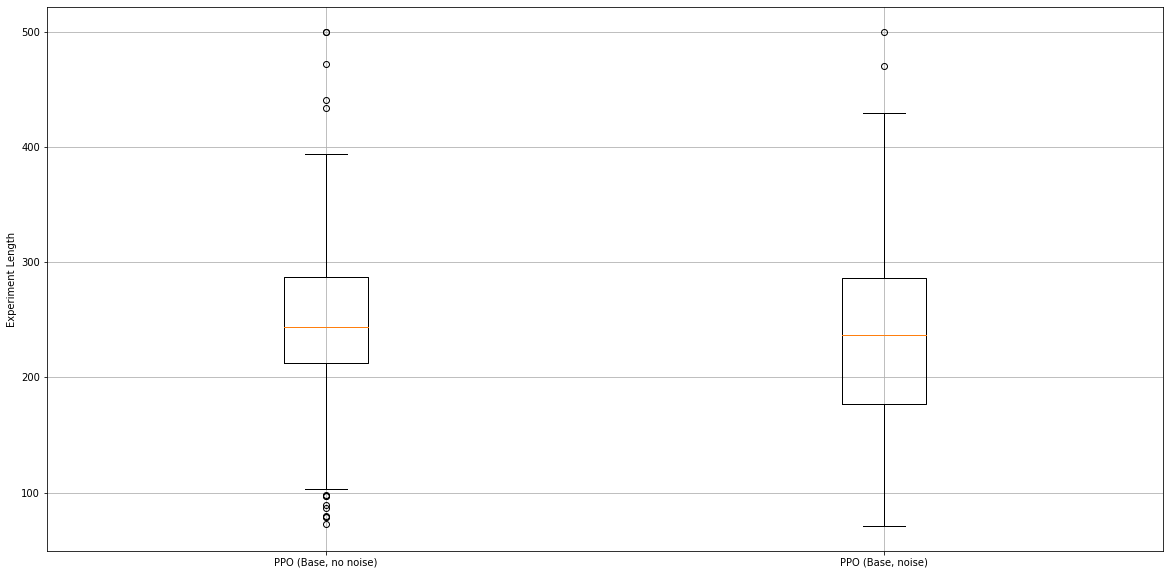

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

boxplot_data  = {}
for i in range(len(variants)):
 boxplot_data[variants[i]] = np.reshape(stepCounter[i],newshape=-1)

plt.boxplot(boxplot_data.values(), labels = boxplot_data.keys())

plt.ylabel("Experiment Length")
plt.savefig(fig_dir + "/ExperimentLength.png")
plt.show()

Noise per Experiment Length

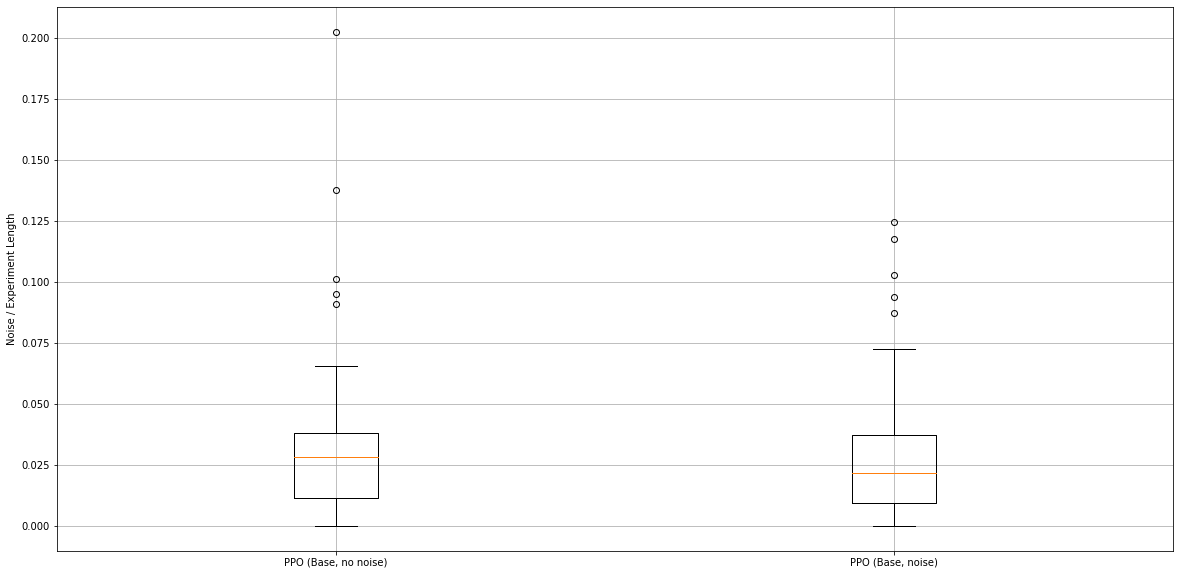

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

boxplot_data  = {}
for i in range(len(variants)):
 boxplot_data[variants[i]] = np.reshape(np.divide(noiseCounter[i],stepCounter[i]),newshape=-1)

plt.boxplot(boxplot_data.values(), labels = boxplot_data.keys())

plt.ylabel("Noise / Experiment Length")
plt.savefig(fig_dir + "/Noise+ExperimentLength.png")
plt.show()

Noise per Length

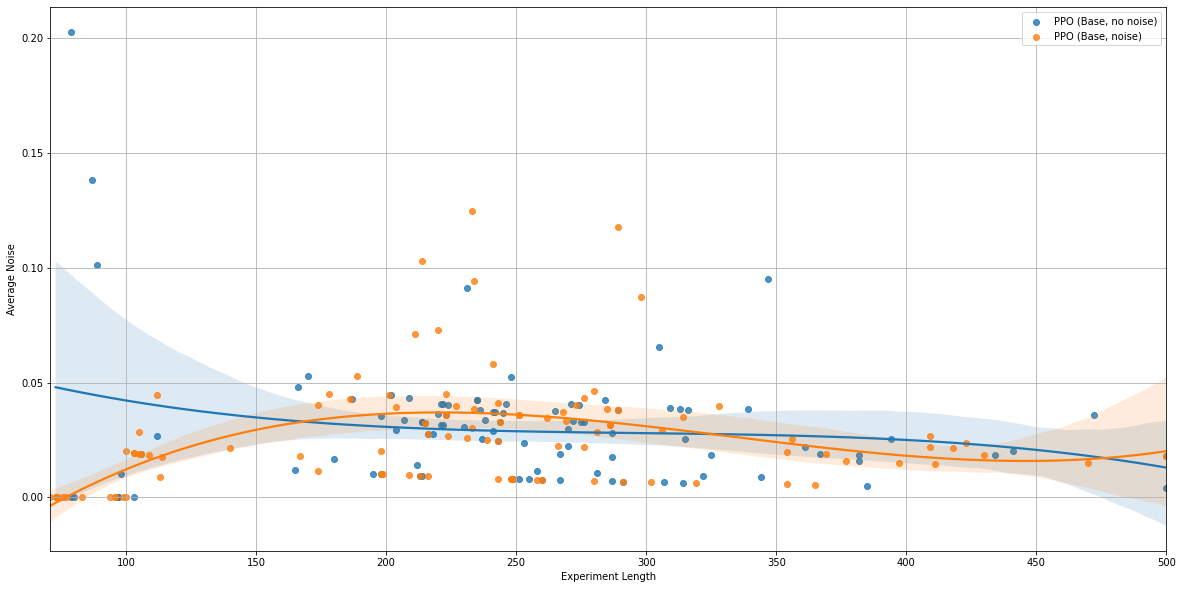

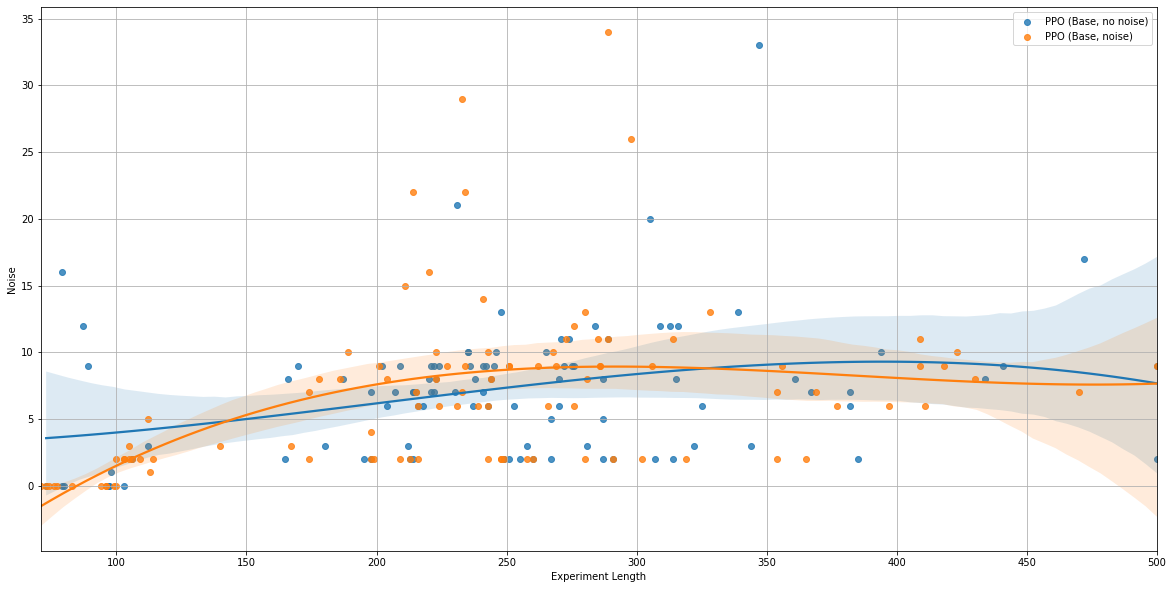

In [ ]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepCounter[i],-1), y=np.reshape(avgNoiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.legend()
regplot.set_ylabel("Average Noise")
regplot.set_xlabel("Experiment Length")
regplot.grid()
plt.savefig(fig_dir + "/AvNoiseLength.png")
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepCounter[i],-1), y=np.reshape(noiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Noise")
regplot.set_xlabel("Experiment Length")
regplot.legend()
regplot.grid()
plt.savefig(fig_dir + "/NoiseLength.png")
plt.show()

Noise per Reward

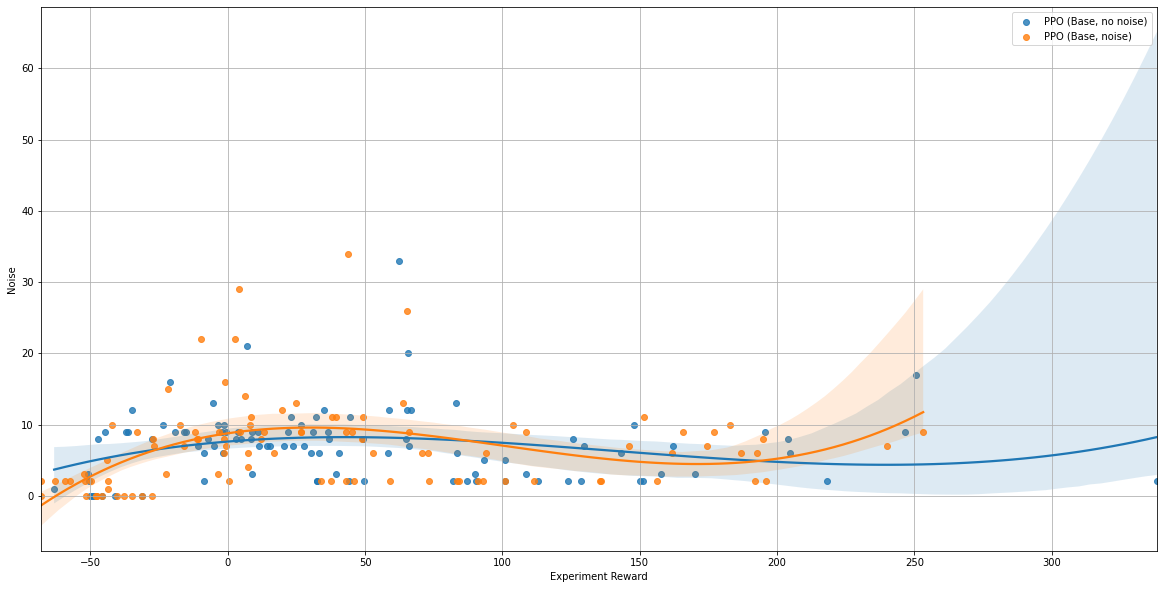

In [ ]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(rewardCounter[i],-1), y=np.reshape(noiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Noise")
regplot.set_xlabel("Experiment Reward")
regplot.legend()
regplot.grid()
plt.savefig(fig_dir + "/NoiseReward.png")
plt.show()

Reward per Experiment Length

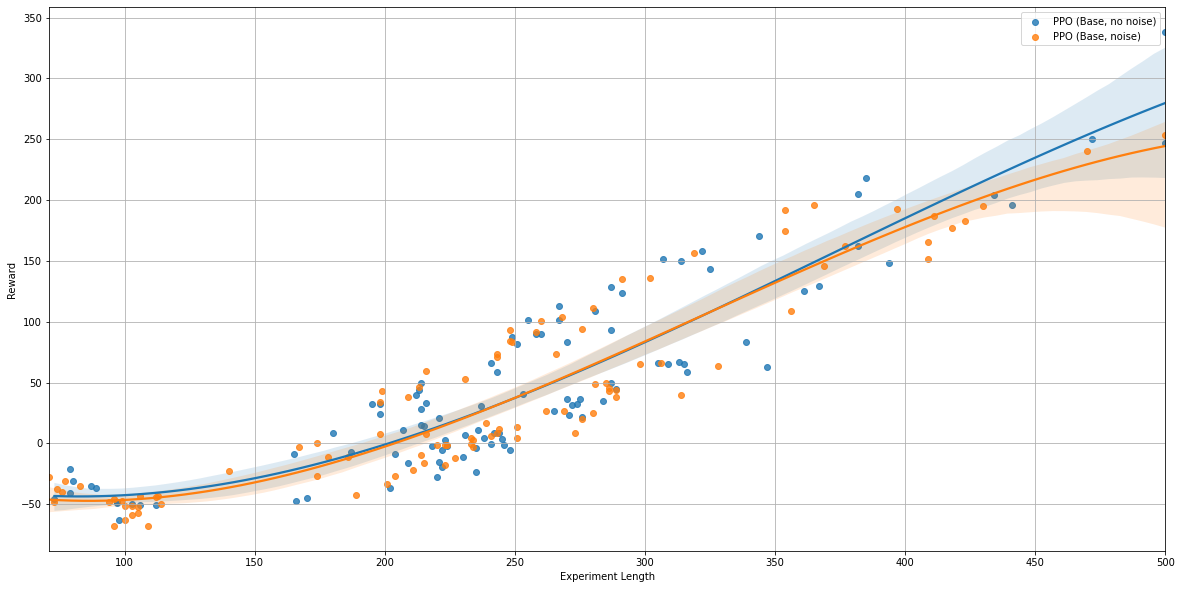

In [ ]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepCounter[i],-1), y=np.reshape(rewardCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Reward")
regplot.set_xlabel("Experiment Length")
regplot.legend()
regplot.grid()
plt.savefig(fig_dir + "/RewardLength.png")
plt.show()

Direction

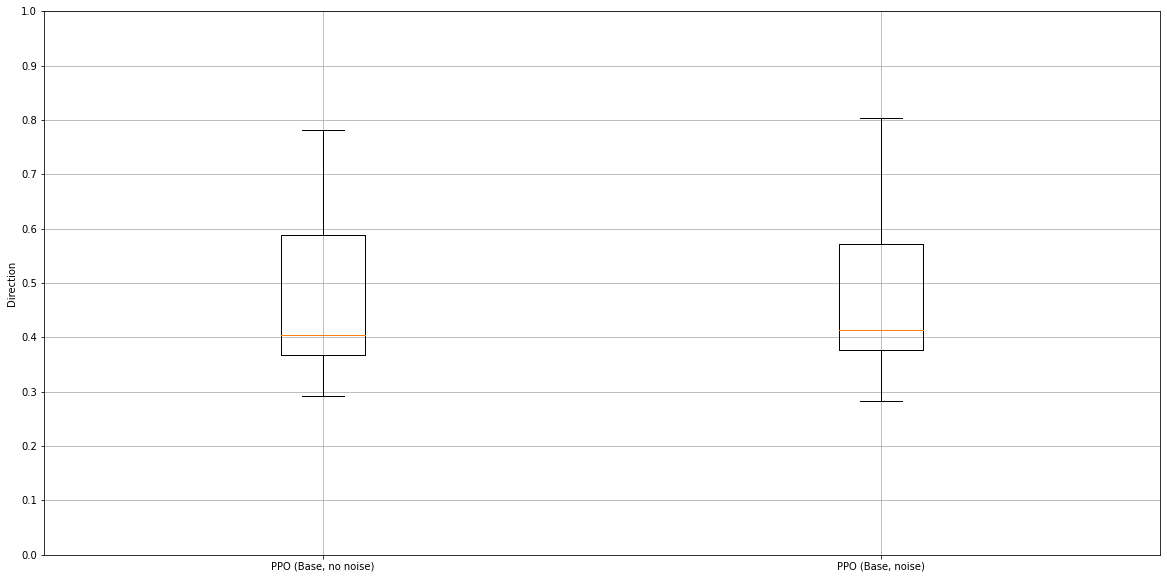

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()


boxplot_data  = {}
for i in range(len(variants)):
 boxplot_data[variants[i]] = np.reshape(stepRatio[i],newshape=-1)

plt.boxplot(boxplot_data.values(), labels = boxplot_data.keys())

plt.ylabel("Direction")

plt.ylim(0,1)
plt.yticks(np.arange(0, 1.01, step=0.1)) 
plt.savefig(fig_dir + "/ExperimentDirection.png")
plt.show()

Experiment Length per Direction

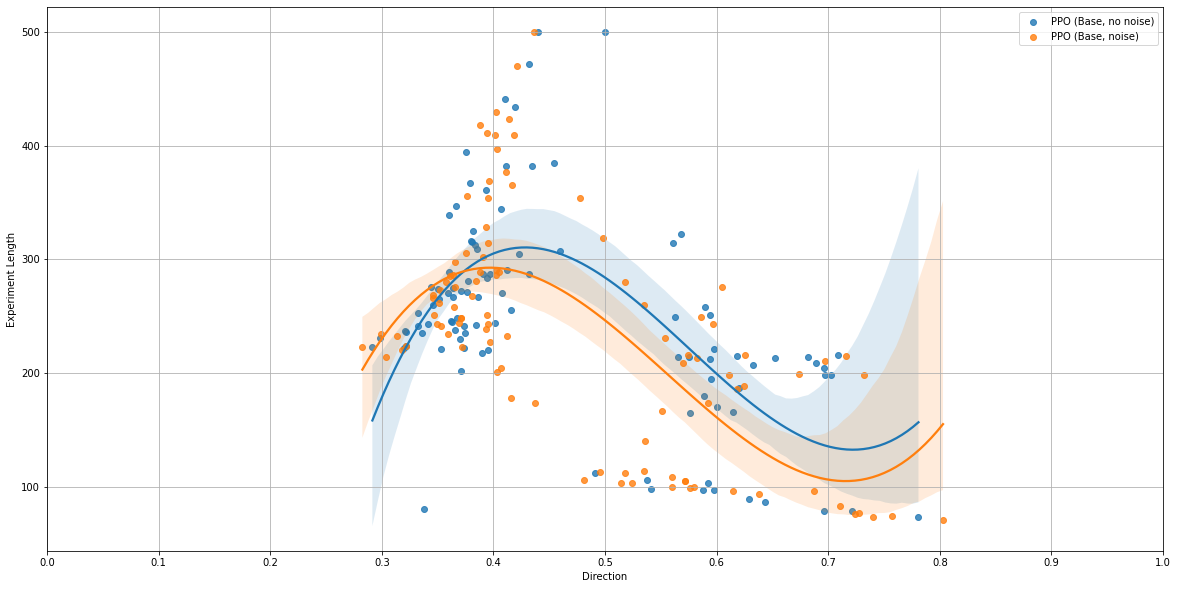

In [ ]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepRatio[i],-1), y=np.reshape(stepCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Experiment Length")
regplot.set_xlabel("Direction")
regplot.legend()
regplot.grid()
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.01, step=0.1)) 
plt.savefig(fig_dir + "/DirectionLength.png")
plt.show()

Reward per Direction

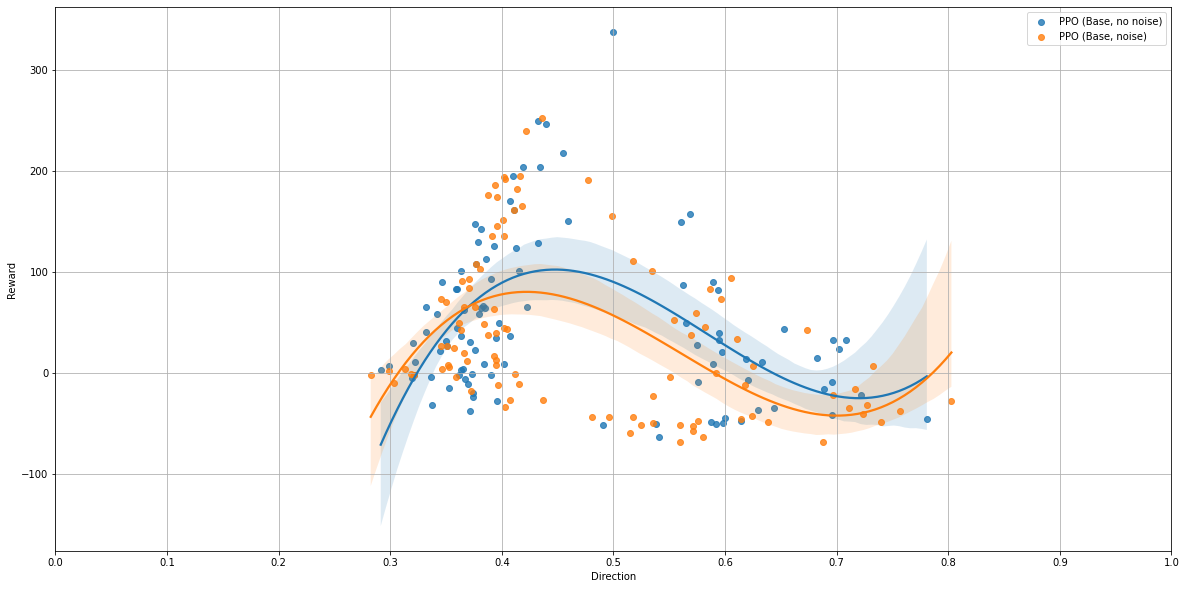

In [ ]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepRatio[i],-1), y=np.reshape(rewardCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Reward")
regplot.set_xlabel("Direction")
regplot.legend()
regplot.grid()
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.01, step=0.1)) 
plt.savefig(fig_dir + "/RewardDirection.png")
plt.show()

Noise per Direction

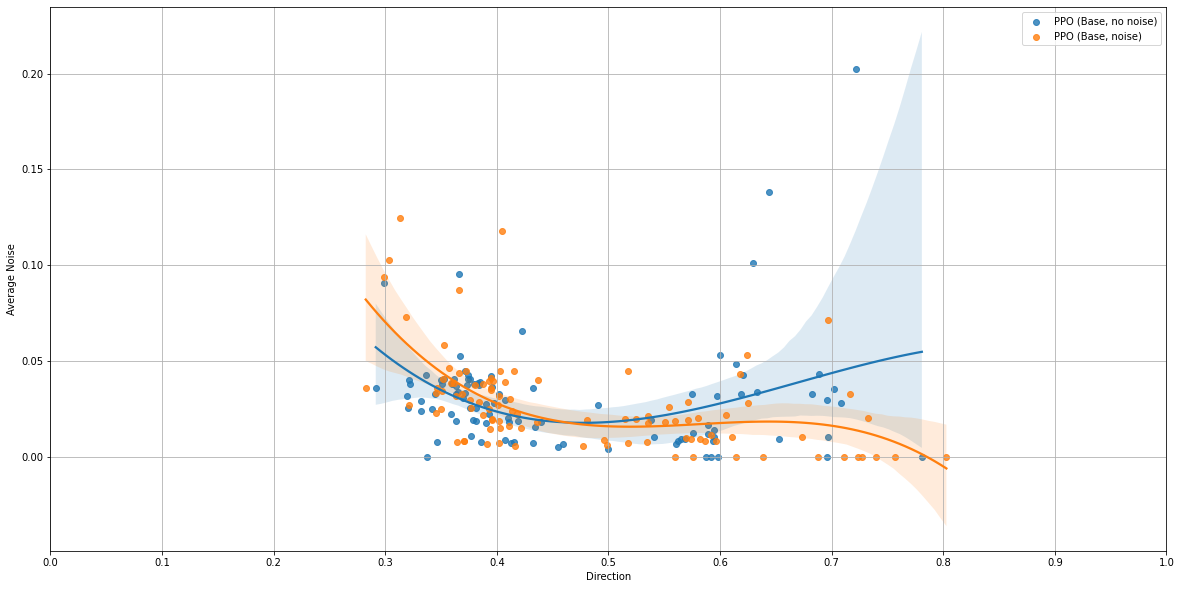

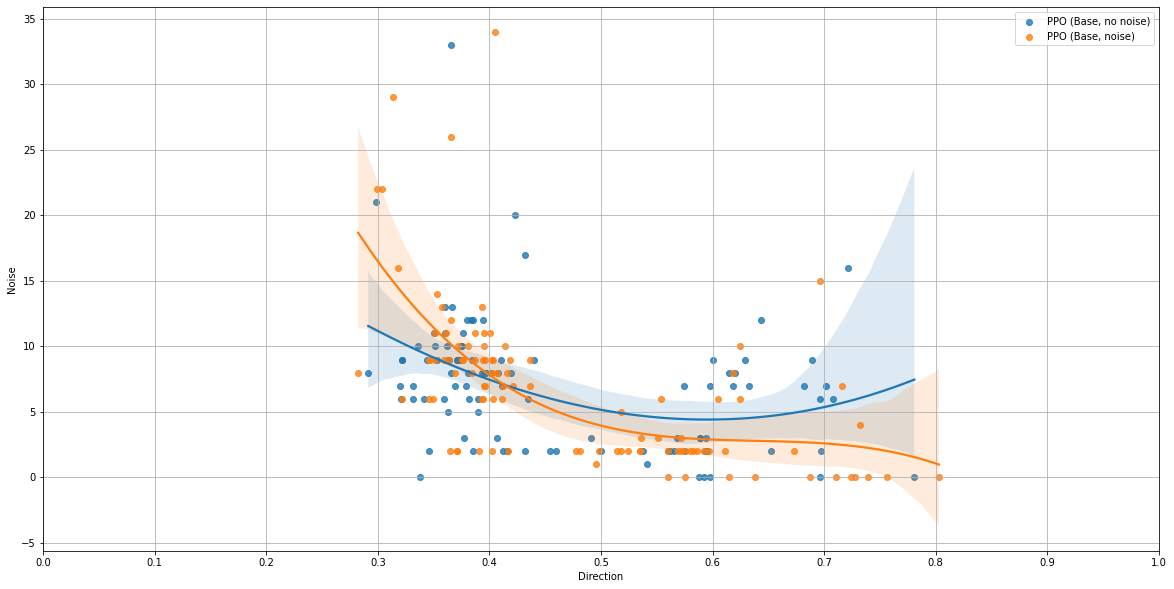

In [ ]:
fig, regplot = plt.subplots(figsize = (20,10))


for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepRatio[i],-1), y=np.reshape(avgNoiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.legend()
regplot.set_ylabel("Average Noise")
regplot.set_xlabel("Direction")
regplot.grid()
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.01, step=0.1)) 
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepRatio[i],-1), y=np.reshape(noiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Noise")
regplot.set_xlabel("Direction")
regplot.legend()
regplot.grid()
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.01, step=0.1)) 
plt.savefig(fig_dir + "/NoiseDirection.png")
plt.show()